# Free Ions

Here are:

- Calculations of energy levels and magnetic dipole transition rates for the free ions quoted by Morrison on Table 1. Results for levels are saved in /data/free_ion_calcs.pkl which is a pandas dataframe.

- Comparison of Hartree-Fock Racah parameters (as compiled by Brik and Ma using Cowan's code `/data/brik_ma_cowan.pkl`) against data from Kurvits.

- Develepment code for `standard_mag_dip`, `mag_dip_xyz`.

- Development code for functions that provide Kurvits' interpolation for Racah parameters: `kurvits_slater_ints_and_SO`, `kurvits_slater_RacahP_and_SO`.

In [1]:
%load_ext autoreload
%autoreload 2
# provide cell timings
%load_ext autotime
from qdef import *
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'retina'
import sympy as sp
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matrixgoodies import *
from uncertainties import ufloat
plot_style = 'default'
plt.style.use(plot_style)

Reloading /Users/juan/ZiaLab/Codebase/qdef/data/CPGs.pkl ...


## Free Ions from Hartree-Fock (Feb 24 2022)

### Calculation of energy levels and states

In [5]:
hf_free_ions = pd.read_pickle('./data/brik_ma_cowan.pkl')

In [17]:
if os.path.exists('./data/hf_free_ion_calcs.pkl'):
    hf_free_ions = pickle.load(open('./data/hf_free_ion_calcs.pkl','rb'))
else:
    all_energies = []
    all_eigenqets = []
    all_eigenvects = []
    l = 2
    for index, row in hf_free_ions.iterrows():
        num_electrons = row['ndN']
        ion = Ion(row['Element'], row['Charge'])
        print(row['Element'], row['Charge'], end='|')
        B, C = row['B/cm^-1'], row['C/cm^-1']
        F2 = 49*B + 7*C
        F4 = 63*C/5
        α = 0.
        ζ = row['ζd/cm^-1']
        dζ = 1
        dα = 0.
        ham = hamiltonian_CF_CR_SO_TO(num_electrons, 'O', l, False, True)
        matrixmah = ham[0].subs({sp.Symbol('B_{4,0}'): 0, sp.Symbol('F^{(0)}'): 0})
        vars = OrderedDict([
            (sp.Symbol('F^{(2)}'), ufloat(F2, 1)),
            (sp.Symbol('F^{(4)}'), ufloat(F4, 1)),
            (sp.Symbol('\\alpha_T'), ufloat(α, dα)),
            (sp.Symbol('\\zeta_{SO}'), ufloat(ζ, dζ))])
        eigenvals = uncertain_eigenvalsh(matrixmah, vars, 100)
        best_estimate_ham = matrixmah.subs({k: v.nominal_value for k,v in vars.items()})
        best_estimate_ham = np.array(best_estimate_ham, dtype=np.complex64)
        eigenvects = np.linalg.eigh(best_estimate_ham)
        all_eigenvects.append(eigenvects[1].T)
        eigenqets = [Qet({k:v for k,v in zip(ham[-1],row)}) for row in (eigenvects[1].T)]
        all_eigenqets.append(eigenqets)
        energies = eigenvals - min(eigenvals)
        all_energies.append(energies)
    hf_free_ions['Energy Levels / cm^{-1}'] = all_energies
    hf_free_ions['Eigenqets'] = all_eigenqets
    hf_free_ions['Eigenvectors'] = all_eigenvects
    hf_free_ions.sort_values(['Z','Charge'], 0, inplace=True)

Sc 2|Ti 2|V 2|Cr 2|Using spherical harmonics basis.
Mn 2|Using spherical harmonics basis.
Fe 2|Using spherical harmonics basis.
Co 2|Using spherical harmonics basis.
Ni 2|Using spherical harmonics basis.
Cu 2|Using spherical harmonics basis.
Zn 2|Using spherical harmonics basis.
Ti 3|V 3|Cr 3|Mn 3|Fe 3|Co 3|Ni 3|Cu 3|Zn 3|Ga 3|V 4|Cr 4|Mn 4|Fe 4|Co 4|Ni 4|Cu 4|Zn 4|Ga 4|Ge 4|Y 2|Zr 2|Nb 2|Mo 2|Tc 2|Ru 2|Rh 2|Pd 2|Ag 2|Cd 2|Y 3|Using spherical harmonics basis.
Zr 3|Nb 3|Mo 3|Tc 3|Ru 3|Rh 3|Pd 3|Ag 3|Cd 3|In 3|Zr 4|Nb 4|Mo 4|Tc 4|Ru 4|Rh 4|Pd 4|Ag 4|Cd 4|In 4|Lu 2|Hf 2|Ta 2|W 2|Re 2|Os 2|Ir 2|Pt 2|Au 2|Hg 2|Lu 3|Hf 3|Ta 3|W 3|Re 3|Os 3|Ir 3|Pt 3|Au 3|Hg 3|Tl 3|Hf 4|Ta 4|W 4|Re 4|Os 4|Ir 4|Pt 4|Au 4|Hg 4|Tl 4|Cr 5|Mn 5|Fe 5|Co 5|Ni 5|Cu 5|Zn 5|Ga 5|Ge 5|As 5|Mn 6|Fe 6|Co 6|Ni 6|Cu 6|Zn 6|Ga 6|Ge 6|As 6|Se 6|Fe 7|Co 7|Ni 7|Cu 7|Zn 7|Ga 7|Ge 7|As 7|Se 7|Br 7|Mo 5|Tc 5|Ru 5|Rh 5|Pd 5|Ag 5|Cd 5|In 5|Sn 5|Sb 5|Tc 6|Ru 6|Rh 6|Pd 6|Ag 6|Cd 6|In 6|Sn 6|Sb 6|Te 6|Ru 7|Rh 7|Pd 7|Ag 7|Cd 7|In 7|Sn 7

In [36]:
# nonz = sum(free_ion_data['Energy Levels / cm^{-1}'].apply(lambda x: len(x) == 0))
# fig, ax = plt.subplots(figsize=(20,30))
# offset = 0
# xmin = 0
# xmax = 15
# done = []
# old_color = 'r'
# if plot_style == 'default':
#     nist_color = 'k'
# else:
#     nist_color = 'w'
# rmses = []
# rmse_dict = {}
# for index in range(len(free_ion_data)):
#     row =  free_ion_data.iloc[index]
#     energies = row['Energy Levels / cm^{-1}']
#     if len(energies) == 0:
#         continue
#     energies = energies * UnitCon.con_factor('cm^{-1}','eV')
#     energies = list(map(lambda x: x.nominal_value, energies))
#     label = '%s${}^{%d\!+}$' % (row['Ion'], row['charge'])
#     if np.isnan(row['ζ']):
#         lζ = '--'
#     else:
#         lζ = '%.0f' % row['ζ']
#     if np.isnan(row['α']):
#         lα = '--'
#     else:
#         lα = '%.0f' % row['α']
#     data = '(F${}^{(2)}$ = %.0f, F${}^{(4)}$ = %.0f, $\\zeta$ = %s, $\\alpha$ = %s) ' % (row['F^2'], row['F^4'], lζ, lα)
#     full_label =  data + label
#     ion = Ion(row['Ion'], row['charge'])
#     gs_config = ion.nist_data_levels['Configuration'][0]
#     if gs_config not in rmse_dict:
#         rmse_dict[gs_config] = []
#     gterm_energies = ion.nist_data_levels['Level (eV)'][ion.nist_data_levels['Configuration'] == gs_config]
#     ngterm_energies = ion.nist_data_levels['Level (eV)'][ion.nist_data_levels['Configuration'] != gs_config]
#     # print(energies, gterm_energies)
#     rm = min_RMSE(list(gterm_energies), list(set(energies)))
#     rmse = '{:.1e}'.format(rm)
#     rmse_dict[gs_config].append(rm)
#     rmses.append(rmse)
#     if label in done:
#         p = ax.plot(energies,[offset]*len(energies),'|', c=old_color)
#     else:
#         offset += 1
#         p = ax.plot(energies,[offset]*len(energies),'|')
#         old_color = p[0].get_color()

#     done.append(label)
#     ax.text(-0.3, offset, full_label, ha = 'right', va = 'center', fontsize=7)
#     ax.plot([0,xmax],[offset]*2,'w-',lw=1, alpha=0.2)
#     offset += 1
#     if (index + 1) < len(free_ion_data):
#         next_row = free_ion_data.iloc[index+1]
#         nextlabel = '%s${}^{%d\!+}$' % (next_row['Ion'], next_row['charge'])
#         if nextlabel != label:
#             # print(nextlabel, label)
#             p = ax.plot(gterm_energies,[offset]*len(gterm_energies),'|', c=nist_color)
#             p = ax.plot(ngterm_energies,[offset]*len(ngterm_energies),'|', c='r')
#             ax.text(-0.3, offset,'NIST : ' + row['nd^N'] + ' | RMSE = ' + '{%s} (eV)' % (', '.join(rmses)), ha = 'right', va = 'center', fontsize=7)
#             rmses = []
#             offset += 1
#     # if index == 2:
#     #     break
# for hoff in range(0,xmax+1):
#     plt.plot([hoff,hoff],[0,offset],nist_color+':', lw=0.5, alpha=0.5)
#     plt.plot([hoff+1/2,hoff+1/2],[0,offset],nist_color+':', lw=0.5, alpha=0.1)
#     plt.plot([hoff+1/4,hoff+1/4],[0,offset],nist_color+':', lw=0.4, alpha=0.1)
#     plt.plot([hoff+3/4,hoff+3/4],[0,offset],nist_color+':', lw=0.4, alpha=0.1)
# ax.set_ylim(-1,offset+1)
# ax.set_xlim(xmin,xmax)
# ax.set_xlabel('E/eV')
# ax.yaxis.set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(True)
# ax.spines['left'].set_visible(False)
# ax.tick_params(axis='x', labelsize=7)
# ax2 = ax.twiny()
# ax2.set_xlim(xmin * UnitCon.con_factor('eV','cm^{-1}'), xmax * UnitCon.con_factor('eV','cm^{-1}') )
# ax2.set_xlabel('E/cm${}^{-1}$')
# ax2.yaxis.set_visible(False)
# ax2.spines['top'].set_visible(True)
# ax2.spines['right'].set_visible(False)
# ax2.spines['bottom'].set_visible(False)
# ax2.spines['left'].set_visible(False)
# ax2.tick_params(axis='x', labelsize=7)
# ax.set_title('Calculated Energy Levels of Free Ions with Comparison to NIST data\n')
# plt.tight_layout()
# plt.savefig('FreeIonCalcs.pdf', bbox_inches ='tight', pad_inches=1)
# plt.show()

### Calculation of MD transition rates

In [41]:
# given a list of energies, and an associated array of vectors
# determine which groups have the same energy to a given tolerance
# and keep a single representative eigenvector together with the degeneracy
# the result should be a list of dictionaries
# each of which has three keys: energy, degeneracy, qet
tolerance = 6
nonz = list((hf_free_ions['Energy Levels / cm^{-1}'].apply(lambda x:len(x)!=0)))
nonz = [idx for idx in range(len(hf_free_ions)) if nonz[idx]]
all_transitions = []
for index in nonz:
    # grab the row for this ion
    row = hf_free_ions.iloc[index]
    # instantiate Ion with additional properties
    ion =  Ion(row['Element'], row['Charge'])
    # num electrons
    num_electrons = row['ndN']
    # energies with uncertainties
    raw_energies = row['Energy Levels / cm^{-1}'] * UnitCon.con_factor('cm^{-1}','eV')
    # strip away the uncertainty
    energies = [x.nominal_value for x in raw_energies]
    # turn into array with given tolerance
    energies_array = np.round(energies,tolerance)
    # determine the indices of equal energies
    uenergies, uindices, degeneracies = np.unique(energies_array, return_index=True, return_counts=True)
    # aggregate all levels in this list
    levels = []
    # eigenstates in rows
    eigenstates = row['Eigenvectors']
    for uenergy, g, uindex in zip(uenergies, degeneracies, uindices):
        level = {}
        level['energy'] = raw_energies[uindex]
        level['g'] = g
        level['index_mask'] = (energies_array == uenergy)
        chosen_eigenstates = eigenstates[energies_array == uenergy]
        rounded_eigenstates = []
        for eigenstate in chosen_eigenstates:
                eigenstate[np.abs(eigenstate)<1e-10] = 0
                norm = np.sqrt(np.sum(np.abs(eigenstate)**2))
                eigenstate = eigenstate/norm
                rounded_eigenstates.append(eigenstate)
        level['eigenvectors'] = np.array(rounded_eigenstates).T
        levels.append(level)

    gs_conf = Ion(row['Element'], row['Charge']).nist_data_levels['Configuration'][0]
    uenergies = np.array(uenergies)
    plot_title = '%s${}^{%d+}$' % (row['Element'], row['Charge'])
    mag_dip_s = standard_mag_dip(num_electrons, 2)[0]
    mag_dip_s = {axis: np.array(mat.subs({sp.Symbol('g_s', real=True): Con.gs}), 
                                dtype=np.complex64) 
                    for axis, mat in mag_dip_s.items()}

    # eigenstates in columns
    eigenstates = eigenstates.T

    this_mag_dip = {}
    for axis in mag_dip_s:
        this_mag_dip[axis] = np.matmul(np.matmul(np.conjugate(eigenstates.T), mag_dip_s[axis]), eigenstates)
    
    Smatrix = sum([np.abs(this_mag_dip[axis])**2 for axis in this_mag_dip])

    # find all the differences in energy between all the level energies
    ΔE = np.subtract.outer(energies_array, energies_array)
    # set the diagonal to nan
    ΔE[ΔE == 0] = np.nan
    # calculate the wavelengths in m
    Δλ = (UnitCon.hc/ΔE) * UnitCon.con_factor('nm','m') # wavelength is initially in nm, convert it to m

    # determine the magnetic dipole transition rate matrix
    A_MD = 16 * Con.π**3 * Con.μ0 * Con.μB**2 / 3 / Con.h / (Δλ**3) * Smatrix
    A_MD = np.abs(A_MD)

    transitions = []
    for idx0, level0 in enumerate(levels):
        energy0 = level0['energy']
        g0 = level0['g']
        mask0 = level0['index_mask']
        for idx1, level1 in enumerate(levels):
            if idx0 == idx1:
                continue
            energy1 = level1['energy']
            wavelength = (UnitCon.hc / (energy0-energy1)) * UnitCon.con_factor('nm','m')
            if wavelength < 0:
                continue
            mask1 = level1['index_mask']
            # pick all the matrix elements that correspond to the transition between
            # these two terms
            totalA_MD = np.sum(A_MD[mask0].T[mask1])/g0
            transition = {'level_i': level0, 'level_f': level1, 'rate/Hz': totalA_MD, 'wavelength/m': wavelength}
            transitions.append(transition)
    all_transitions.append(transitions)

In [66]:
import h5py
h5_file = h5py.File('free_ion_HF.h5','w')
for index in nonz:
    row = hf_free_ions.iloc[index]
    transitions = all_transitions[index]
    waves = [transition['wavelength/m'].nominal_value for transition in transitions]
    rates = [transition['rate/Hz'] for transition in transitions]
    waves_address = '/%s/%d/waves' % (row['Element'], row['Charge']) 
    rates_address = '/%s/%d/rates' % (row['Element'], row['Charge']) 
    h5_file.create_dataset(waves_address, data = waves)
    h5_file.create_dataset(rates_address, data = rates)
h5_file.close()

## Calculation of energy levels & Comparison to NIST

In [370]:
def min_RMSE(nums0, nums1):
    '''
    Given  two  1D  arrays  of not necessarily the same dimension find the
    minimum  RMSE  between  the  two  sets, by going through the values of
    nums0, finding the minimum square difference with an element of nums1,
    and  aggregating  those through their mean, and then taking the square
    root.
    '''
    nums0 = np.array(nums0)
    nums1 = np.array(nums1)
    nums0 = nums0[nums0 != 0]
    nums1 = nums1[nums1 != 0]
    tot_diff = 0
    for num0 in nums0:
        diffs = np.abs(nums1 - num0)**2
        tot_diff += np.min(diffs)
    return np.sqrt(tot_diff)/len(nums0)

In [371]:
if os.path.exists('./data/free_ion_calcs.pkl'):
    free_ion_data = pickle.load(open('./data/free_ion_calcs.pkl', 'rb'))
else:
    free_ion_data = morrison['Free-ion params']
    free_ion_data['N'] = free_ion_data['nd^N'].apply(lambda x: int(x[-1]))
    alpha_sig_pos = '''0 0 0 -1 -2 -2 0 -2 0 -2 0 -2 -2 0 -2 0 -2 -1 -2 -2 0 -2 0 -2 -1 -2 -2 -2 -2 0 -2 -2 -2 -2 0 -2 -2 -2 -2 0 -2 -2 -2 -2 0 0 0
0 0 0 0 -2 0 0 -2 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 0 0 -1 -1 0 0 -1 -2 -2 0 0 0 0
0 0 0 0 -2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'''
    alpha_sig_pos = list(map(int, alpha_sig_pos.replace('\n',' ').split(' ')))
    all_energies = []
    all_eigenqets = []
    all_eigenvects = []
    l = 2
    for index, row in free_ion_data.iterrows():
        print(row['Ion'], end='|')
        num_electrons = row['N']
        ion = Ion(row['Ion'], row['charge'])
        F2, F4 = row['F^2'], row['F^4']
        α = row['α']
        dα = 10**(alpha_sig_pos[index])
        ζ = row['ζ']
        if any(list(map(np.isnan, [F2, F4]))):
            all_energies.append([])
            all_eigenqets.append([])
            all_eigenvects.append([])
            continue
        if np.isnan(α):
            α = 0
            dα = 0
        if np.isnan(ζ):
            ζ = 0
            dζ = 0
        dζ = 1
        ham = hamiltonian_CF_CR_SO_TO(num_electrons, 'O', l, False, True)
        matrixmah = ham[0].subs({sp.Symbol('B_{4,0}'): 0, sp.Symbol('F^{(0)}'): 0})
        vars = OrderedDict([
            (sp.Symbol('F^{(2)}'), ufloat(F2, 1)),
            (sp.Symbol('F^{(4)}'), ufloat(F4, 1)),
            (sp.Symbol('\\alpha_T'), ufloat(α, dα)),
            (sp.Symbol('\\zeta_{SO}'), ufloat(ζ, dζ))])
        eigenvals = uncertain_eigenvalsh(matrixmah, vars, 100)
        best_estimate_ham = matrixmah.subs({k: v.nominal_value for k,v in vars.items()})
        best_estimate_ham = np.array(best_estimate_ham, dtype=np.complex64)
        eigenvects = np.linalg.eigh(best_estimate_ham)
        all_eigenvects.append(eigenvects[1].T)
        eigenqets = [Qet({k:v for k,v in zip(ham[-1],row)}) for row in (eigenvects[1].T)]
        all_eigenqets.append(eigenqets)
        energies = eigenvals - min(eigenvals)
        all_energies.append(energies)
    free_ion_data['Energy Levels / cm^{-1}'] = all_energies
    free_ion_data['Eigenqets'] = all_eigenqets
    free_ion_data['Eigenvectors'] = all_eigenvects
    free_ion_data['Atomic Number'] = free_ion_data['Ion'].apply(lambda x: Atom(x).atomic_number)
    free_ion_data.sort_values(['Atomic Number','charge'], 0, inplace=True)
    pickle.dump(free_ion_data, open('./data/free_ion_calcs.pkl','wb'))

<ipython-input-370-a865eeeda402>:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(tot_diff)/len(nums0)
<ipython-input-370-a865eeeda402>:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(tot_diff)/len(nums0)
<ipython-input-370-a865eeeda402>:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(tot_diff)/len(nums0)
<ipython-input-370-a865eeeda402>:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(tot_diff)/len(nums0)
<ipython-input-370-a865eeeda402>:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(tot_diff)/len(nums0)
<ipython-input-370-a865eeeda402>:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(tot_diff)/len(nums0)
<ipython-input-370-a865eeeda402>:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(tot_diff)/len(nums0)
<ipython-input-370-a865eeeda402>:17: RuntimeWarning: in

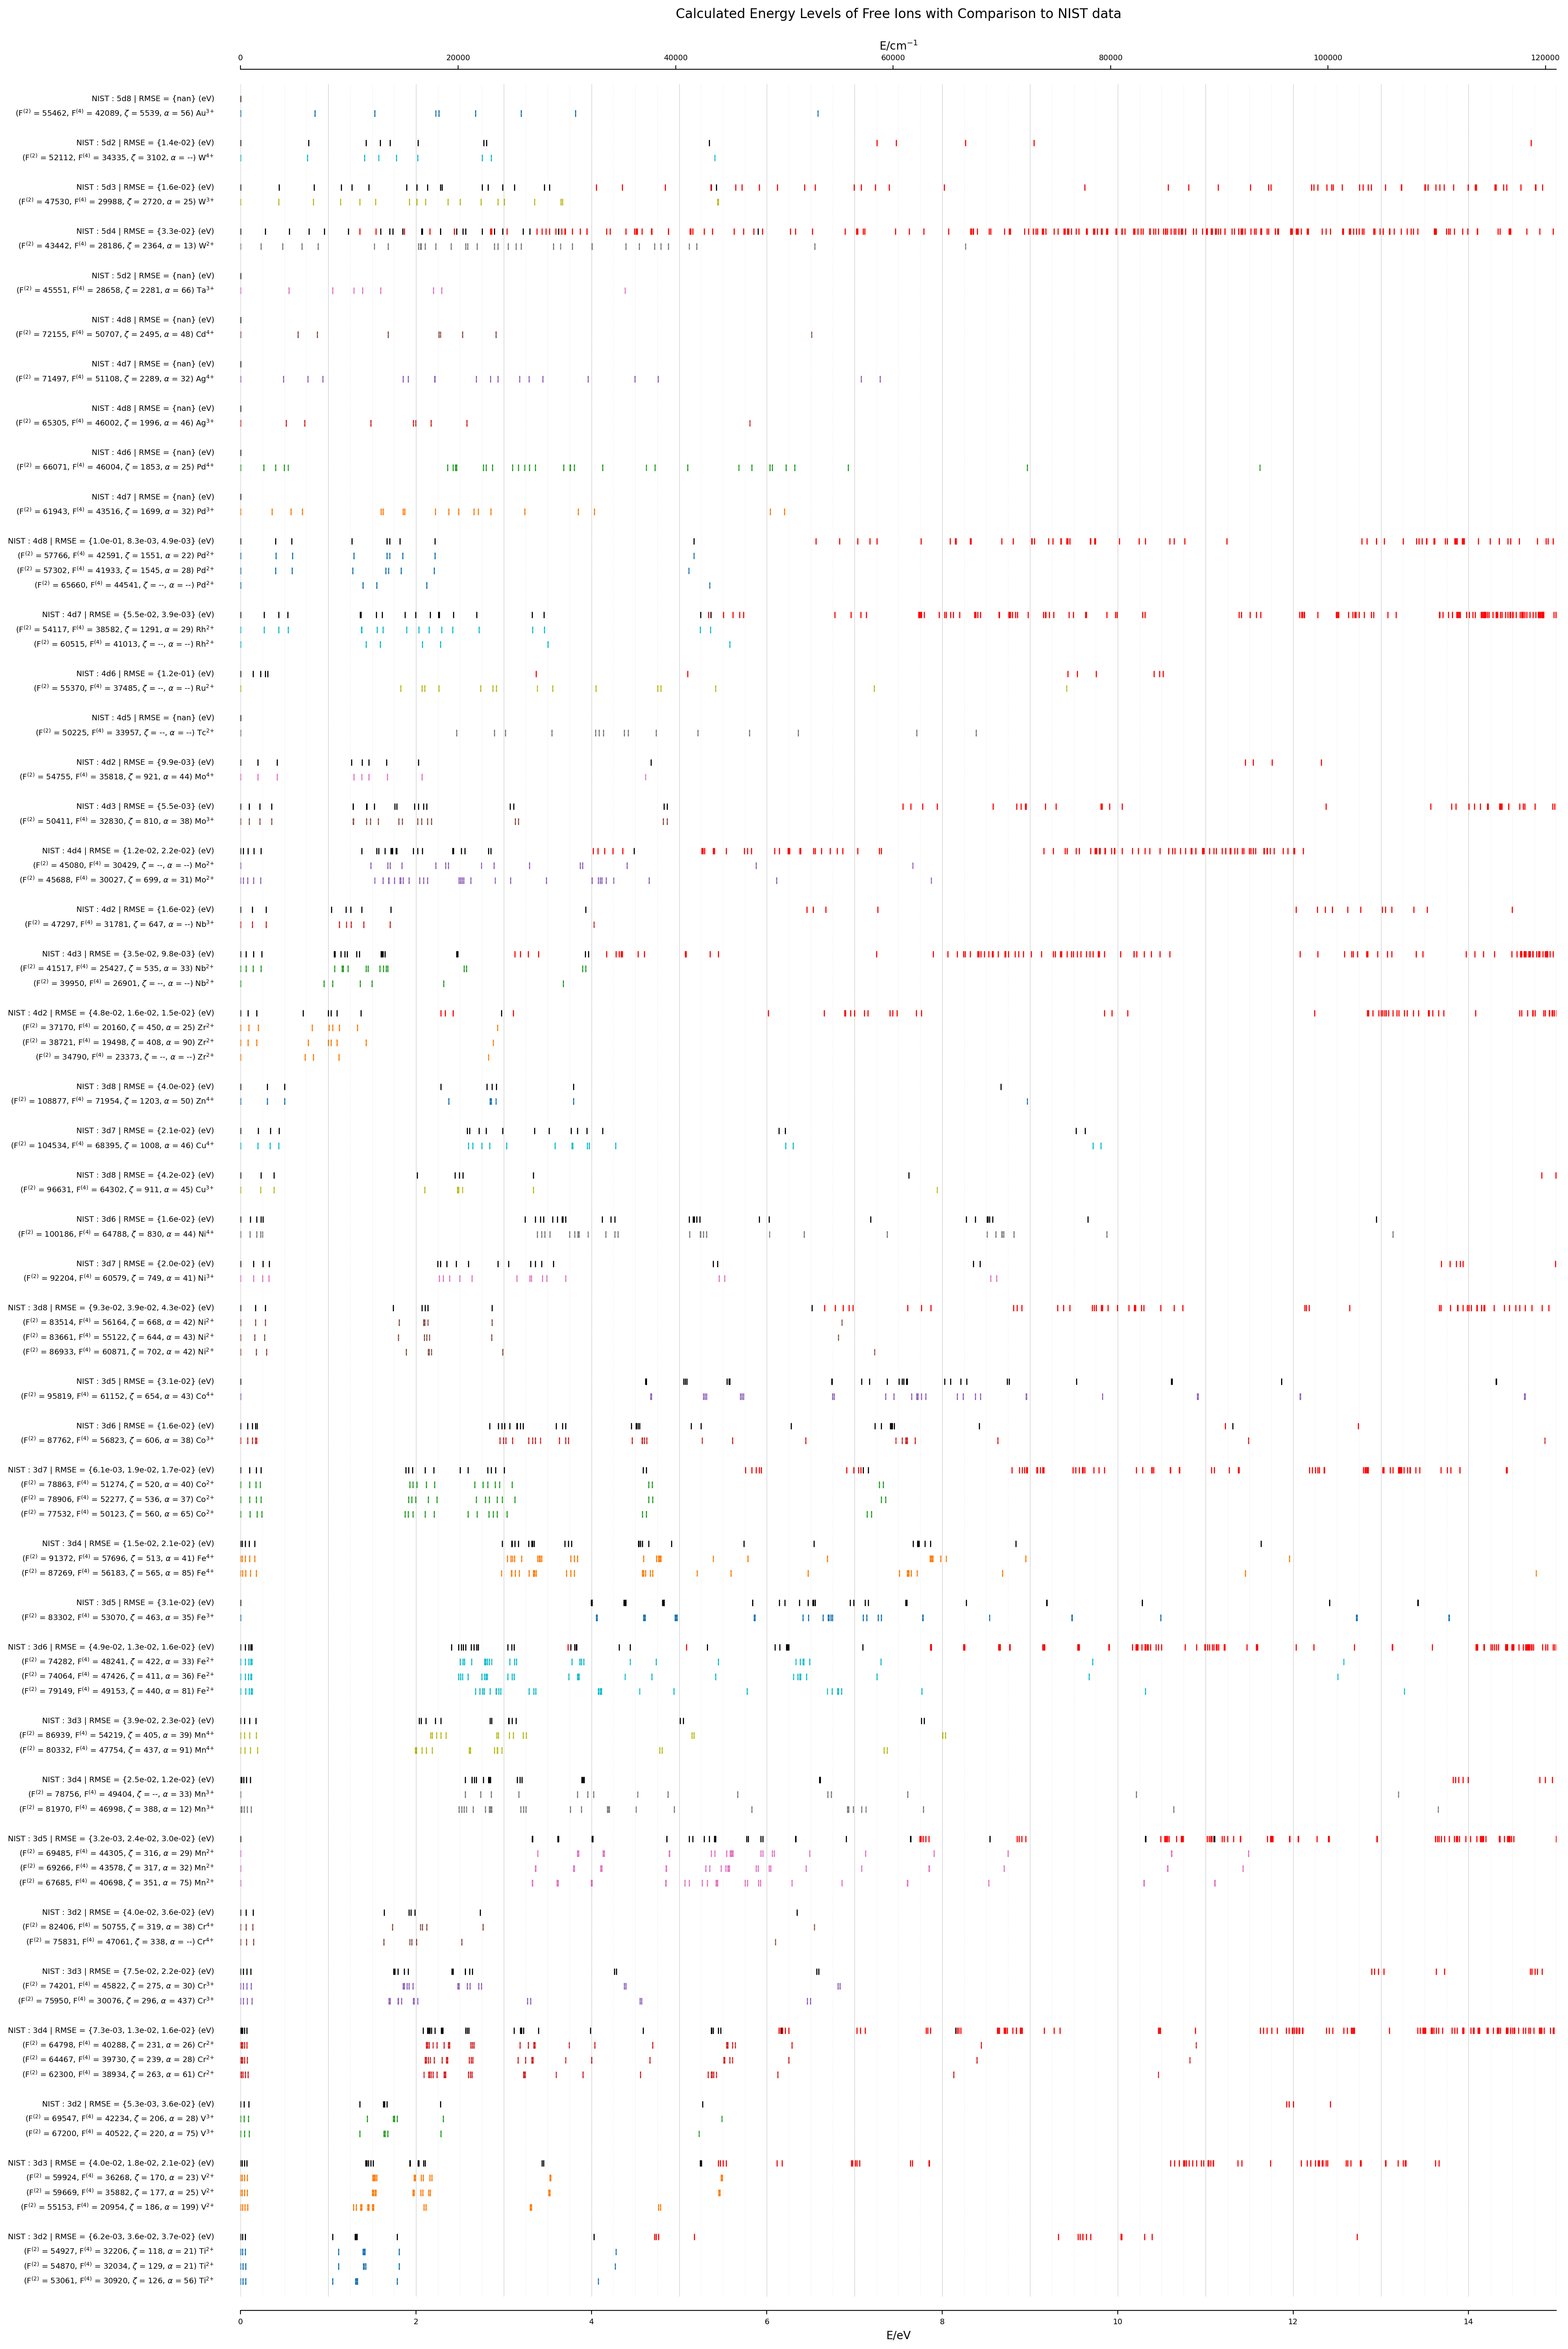

In [379]:
nonz = sum(free_ion_data['Energy Levels / cm^{-1}'].apply(lambda x: len(x) == 0))
fig, ax = plt.subplots(figsize=(20,30))
offset = 0
xmin = 0
xmax = 15
done = []
old_color = 'r'
if plot_style == 'default':
    nist_color = 'k'
else:
    nist_color = 'w'
rmses = []
rmse_dict = {}
for index in range(len(free_ion_data)):
    row =  free_ion_data.iloc[index]
    energies = row['Energy Levels / cm^{-1}']
    if len(energies) == 0:
        continue
    energies = energies * UnitCon.con_factor('cm^{-1}','eV')
    energies = list(map(lambda x: x.nominal_value, energies))
    label = '%s${}^{%d\!+}$' % (row['Ion'], row['charge'])
    if np.isnan(row['ζ']):
        lζ = '--'
    else:
        lζ = '%.0f' % row['ζ']
    if np.isnan(row['α']):
        lα = '--'
    else:
        lα = '%.0f' % row['α']
    data = '(F${}^{(2)}$ = %.0f, F${}^{(4)}$ = %.0f, $\\zeta$ = %s, $\\alpha$ = %s) ' % (row['F^2'], row['F^4'], lζ, lα)
    full_label =  data + label
    ion = Ion(row['Ion'], row['charge'])
    gs_config = ion.nist_data_levels['Configuration'][0]
    if gs_config not in rmse_dict:
        rmse_dict[gs_config] = []
    gterm_energies = ion.nist_data_levels['Level (eV)'][ion.nist_data_levels['Configuration'] == gs_config]
    ngterm_energies = ion.nist_data_levels['Level (eV)'][ion.nist_data_levels['Configuration'] != gs_config]
    # print(energies, gterm_energies)
    rm = min_RMSE(list(gterm_energies), list(set(energies)))
    rmse = '{:.1e}'.format(rm)
    rmse_dict[gs_config].append(rm)
    rmses.append(rmse)
    if label in done:
        p = ax.plot(energies,[offset]*len(energies),'|', c=old_color)
    else:
        offset += 1
        p = ax.plot(energies,[offset]*len(energies),'|')
        old_color = p[0].get_color()

    done.append(label)
    ax.text(-0.3, offset, full_label, ha = 'right', va = 'center', fontsize=7)
    ax.plot([0,xmax],[offset]*2,'w-',lw=1, alpha=0.2)
    offset += 1
    if (index + 1) < len(free_ion_data):
        next_row = free_ion_data.iloc[index+1]
        nextlabel = '%s${}^{%d\!+}$' % (next_row['Ion'], next_row['charge'])
        if nextlabel != label:
            # print(nextlabel, label)
            p = ax.plot(gterm_energies,[offset]*len(gterm_energies),'|', c=nist_color)
            p = ax.plot(ngterm_energies,[offset]*len(ngterm_energies),'|', c='r')
            ax.text(-0.3, offset,'NIST : ' + row['nd^N'] + ' | RMSE = ' + '{%s} (eV)' % (', '.join(rmses)), ha = 'right', va = 'center', fontsize=7)
            rmses = []
            offset += 1
    # if index == 2:
    #     break
for hoff in range(0,xmax+1):
    plt.plot([hoff,hoff],[0,offset],nist_color+':', lw=0.5, alpha=0.5)
    plt.plot([hoff+1/2,hoff+1/2],[0,offset],nist_color+':', lw=0.5, alpha=0.1)
    plt.plot([hoff+1/4,hoff+1/4],[0,offset],nist_color+':', lw=0.4, alpha=0.1)
    plt.plot([hoff+3/4,hoff+3/4],[0,offset],nist_color+':', lw=0.4, alpha=0.1)
ax.set_ylim(-1,offset+1)
ax.set_xlim(xmin,xmax)
ax.set_xlabel('E/eV')
ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', labelsize=7)
ax2 = ax.twiny()
ax2.set_xlim(xmin * UnitCon.con_factor('eV','cm^{-1}'), xmax * UnitCon.con_factor('eV','cm^{-1}') )
ax2.set_xlabel('E/cm${}^{-1}$')
ax2.yaxis.set_visible(False)
ax2.spines['top'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(axis='x', labelsize=7)
ax.set_title('Calculated Energy Levels of Free Ions with Comparison to NIST data\n')
plt.tight_layout()
plt.savefig('FreeIonCalcs.pdf', bbox_inches ='tight', pad_inches=1)
plt.show()

In [380]:
!beep

In [2]:
!open FreeIonCalcs.pdf

The file /Users/juan/ZiaLab/Codebase/qdef/FreeIonCalcs.pdf does not exist.


In [3]:
!open .

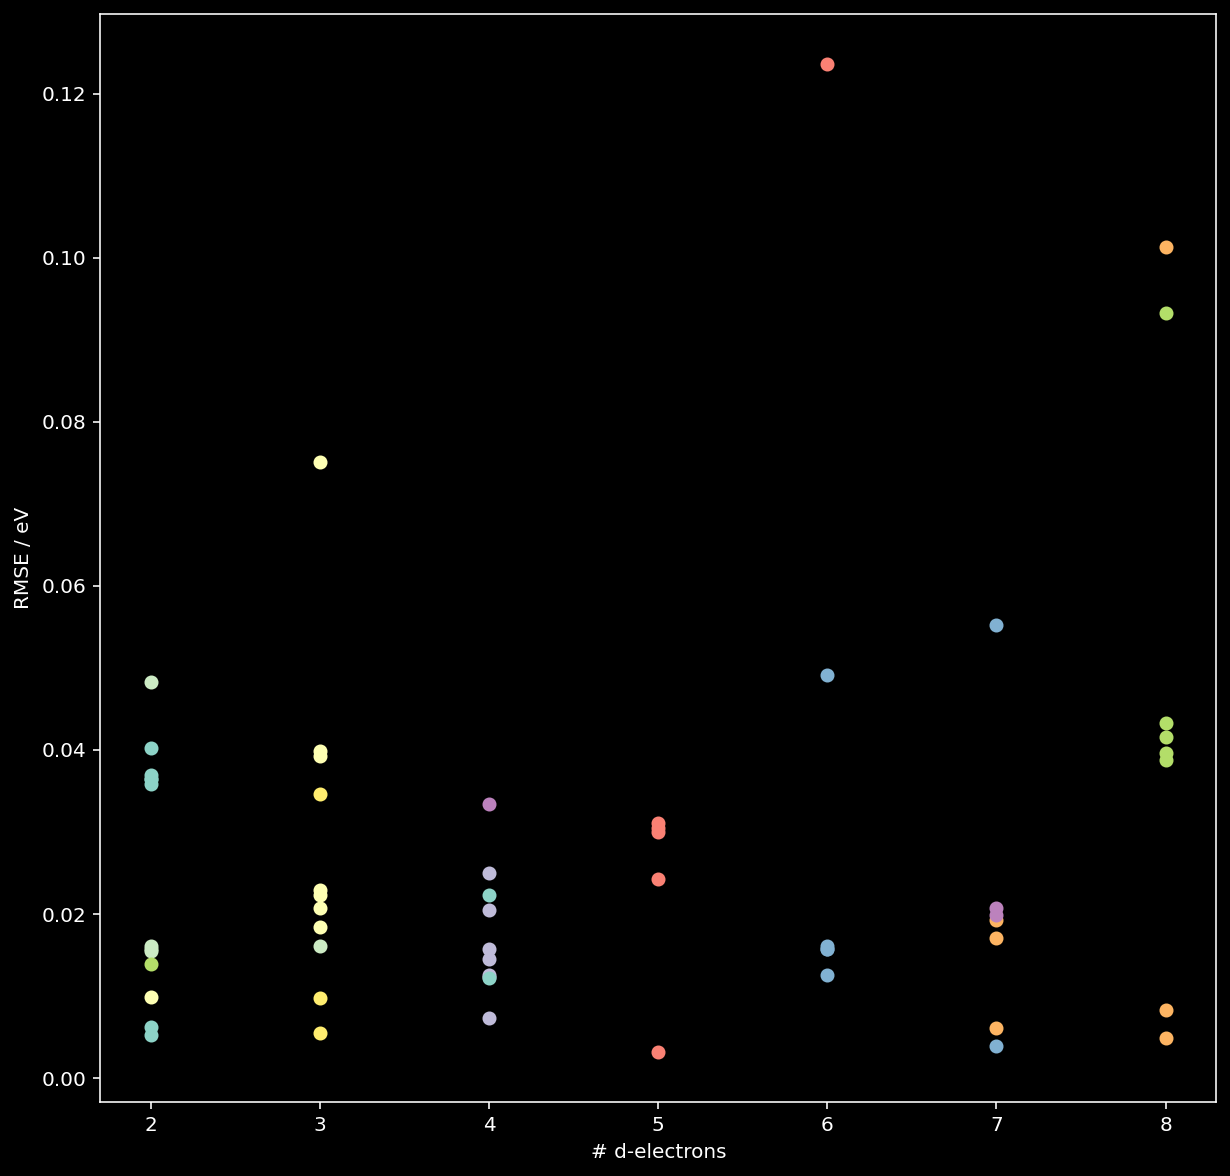

In [142]:
# comparison of discrepancy in levels across different valencies
plt.figure(figsize=(10,10))
for k in rmse_dict:
    x = int(k[-1])
    vals = rmse_dict[k]
    vals = np.array(vals)
    vals = vals[~np.isnan(vals)]
    plt.plot([x]*len(vals), vals, 'o')
plt.xlabel('# d-electrons')
plt.ylabel('RMSE / eV')
plt.show()

## Calculation of transition rates

### Magnetic dipole operator in the standard basis (development code)

In [8]:
# def mag_dip_xyz(axis, l):
#     '''
#     Parameters
#     ----------
#     axis (str) ∈ {'x', 'y', 'z'}
#     l    (int) : orbital angulr momentum
#     Returns
#     -------
#     mag_dip_fun (function) a function which can be used to evaluate matrix
#     elements  in  qets  which  represent a matrix element for the magnetic
#     dipole  operator  taking  the  standard  basis  as the single electron
#     basis used to build multielectron determinantal states.
#     '''
#     axis_index = {'x':0, 'y':1, 'z':2}[axis]
#     L_orbital = Jmatrices(l, False, as_dict=True)
#     L_spin = Jmatrices(1/2, False, as_dict=True)
#     def mag_dip_fun(qnums, coeff):
#         orb0, orb1 = qnums
#         gs = sp.Symbol('g_s', real=True)
#         orbital_contrib, spin_contrib = 0, 0
#         if orb0.spin == orb1.spin:
#             orbital_contrib = L_orbital[axis_index][(orb0.orbital[1], orb1.orbital[1])]
#         if orb0.orbital == orb1.orbital:
#             spin_contrib = L_spin[axis_index][(orb0.spin, orb1.spin)]
#         return {1: coeff*(orbital_contrib + gs * spin_contrib)}
#     return mag_dip_fun

# def standard_mag_dip(num_electrons, l):
#     '''

#     Compute  the  matrix  elements  of the magnetic dipole operator in the
#     standard basis for a system with the given number of electrons.

#         -\mu_B * (L + g_s S)

#     Parameters
#     ----------
#     num_electrons (int) :
#     l             (l)   :

#     Returns
#     -------
#     mag_dip_matrices, mag_dip_operator (tuple) with
#         mag_dip_matrices  (OrderedDict): with keys 'x', 'y', 'z' and
#         values  sp.Matrix mag_dip_operators (OrderedDict): with keys
#         'x',  'y',  'z' and values OrderedDict whose keys are tuples
#         with as many SpinOrbital as num_electrons there are.
    
#     '''
#     if (num_electrons,l) in standard_mag_dip.values:
#         return standard_mag_dip.values[(num_electrons, l)]
#     mag_dip = {axis: mag_dip_xyz(axis, l) for axis in 'xyz'}
    
#     single_e_spin_orbitals = [SpinOrbital((l,m), spin) 
#                                 for spin in [S_DOWN, S_UP] for m in range(-l,l+1)]
#     slater_dets = list(combinations(single_e_spin_orbitals, num_electrons))
#     slater_qets = [Qet({k:1}) for k in slater_dets]

#     mag_dip_operator = OrderedDict()
#     mag_dip_operator['x'] = OrderedDict()
#     mag_dip_operator['y'] = OrderedDict()
#     mag_dip_operator['z'] = OrderedDict()

#     mag_dip_matrices = OrderedDict([('x',[]),('y',[]),('z',[])])
#     for qet0 in slater_qets:
#         row = {'x':[], 'y':[], 'z':[]}
#         qet0key = list(qet0.dict.keys())[0]
#         for qet1 in slater_qets:
#             qet1key = list(qet1.dict.keys())[0]
#             key = (qet0key, qet1key)
#             for axis in mag_dip:
#                 if (qet1key, qet0key) in mag_dip_operator[axis]:
#                     braket = sp.conjugate(mag_dip_operator[axis][(qet1key, qet0key)])
#                     mag_dip_operator[axis][key] = braket
#                     row[axis].append(braket)
#                 else:
#                     braket = -single_electron_braket(qet0, qet1).apply(mag_dip[axis]).as_symbol_sum()
#                     mag_dip_operator[axis][key] = braket
#                     row[axis].append(braket)
#         for axis in row:
#             mag_dip_matrices[axis].append(row[axis])
#     mag_dip_matrices = {axis: sp.Matrix(mag_dip_matrices[axis]) for axis in mag_dip_matrices}
#     standard_mag_dip.values[(num_electrons, l)] = (mag_dip_matrices, mag_dip_operator)
#     return mag_dip_matrices, mag_dip_operator
# standard_mag_dip.values = {}

Reloading /Users/juan/ZiaLab/Codebase/qdef/data/CPGs.pkl ...


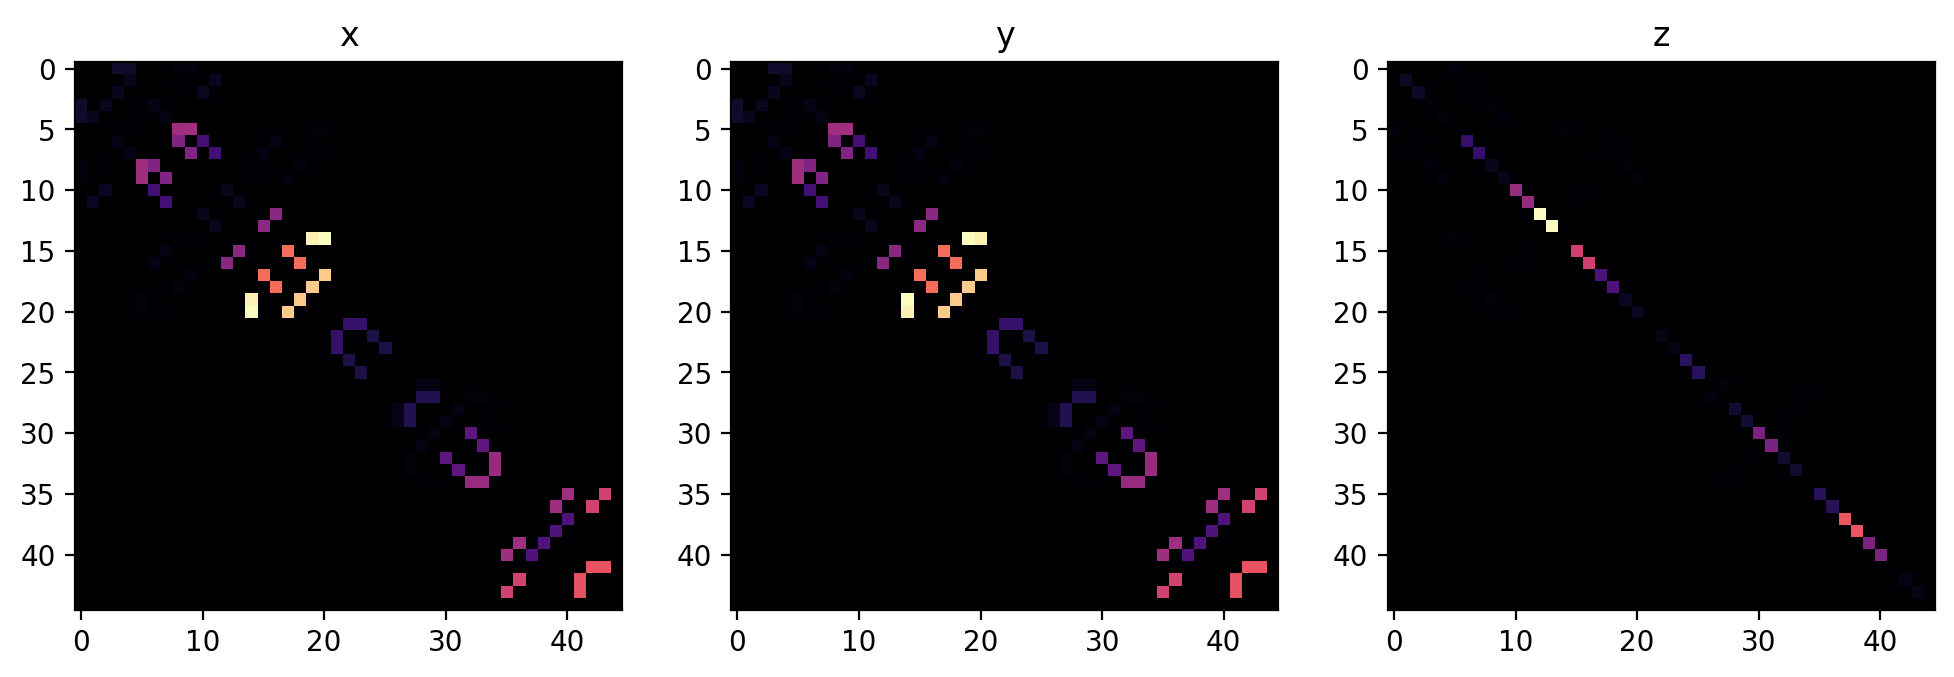

In [383]:
# threshold = 1e-10 qets
num_electrons = 2
l = 2 
mag_dip_s = standard_mag_dip(num_electrons, l)[0]
mag_dip_s = {axis: np.array(mat.subs({sp.Symbol('g_s', real=True): Con.gs}),dtype=np.complex64) for axis, mat in mag_dip_s.items()}
eigenstates = free_ion_data.iloc[1]['Eigenvectors'].T

this_mag_dip = {}
for axis in mag_dip_s:
    this_mag_dip[axis] = np.matmul(np.matmul(np.conjugate(eigenstates.T), mag_dip_s[axis]), eigenstates)
fig, ax = plt.subplots(ncols=3, figsize=(12,4))
for idx, axis in enumerate(this_mag_dip):
    ax[idx].imshow(np.abs(this_mag_dip[axis])**2, cmap='magma')
    ax[idx].set_title(axis)
plt.show()

### Single Ion (Use to polish the calculation of next subsection)

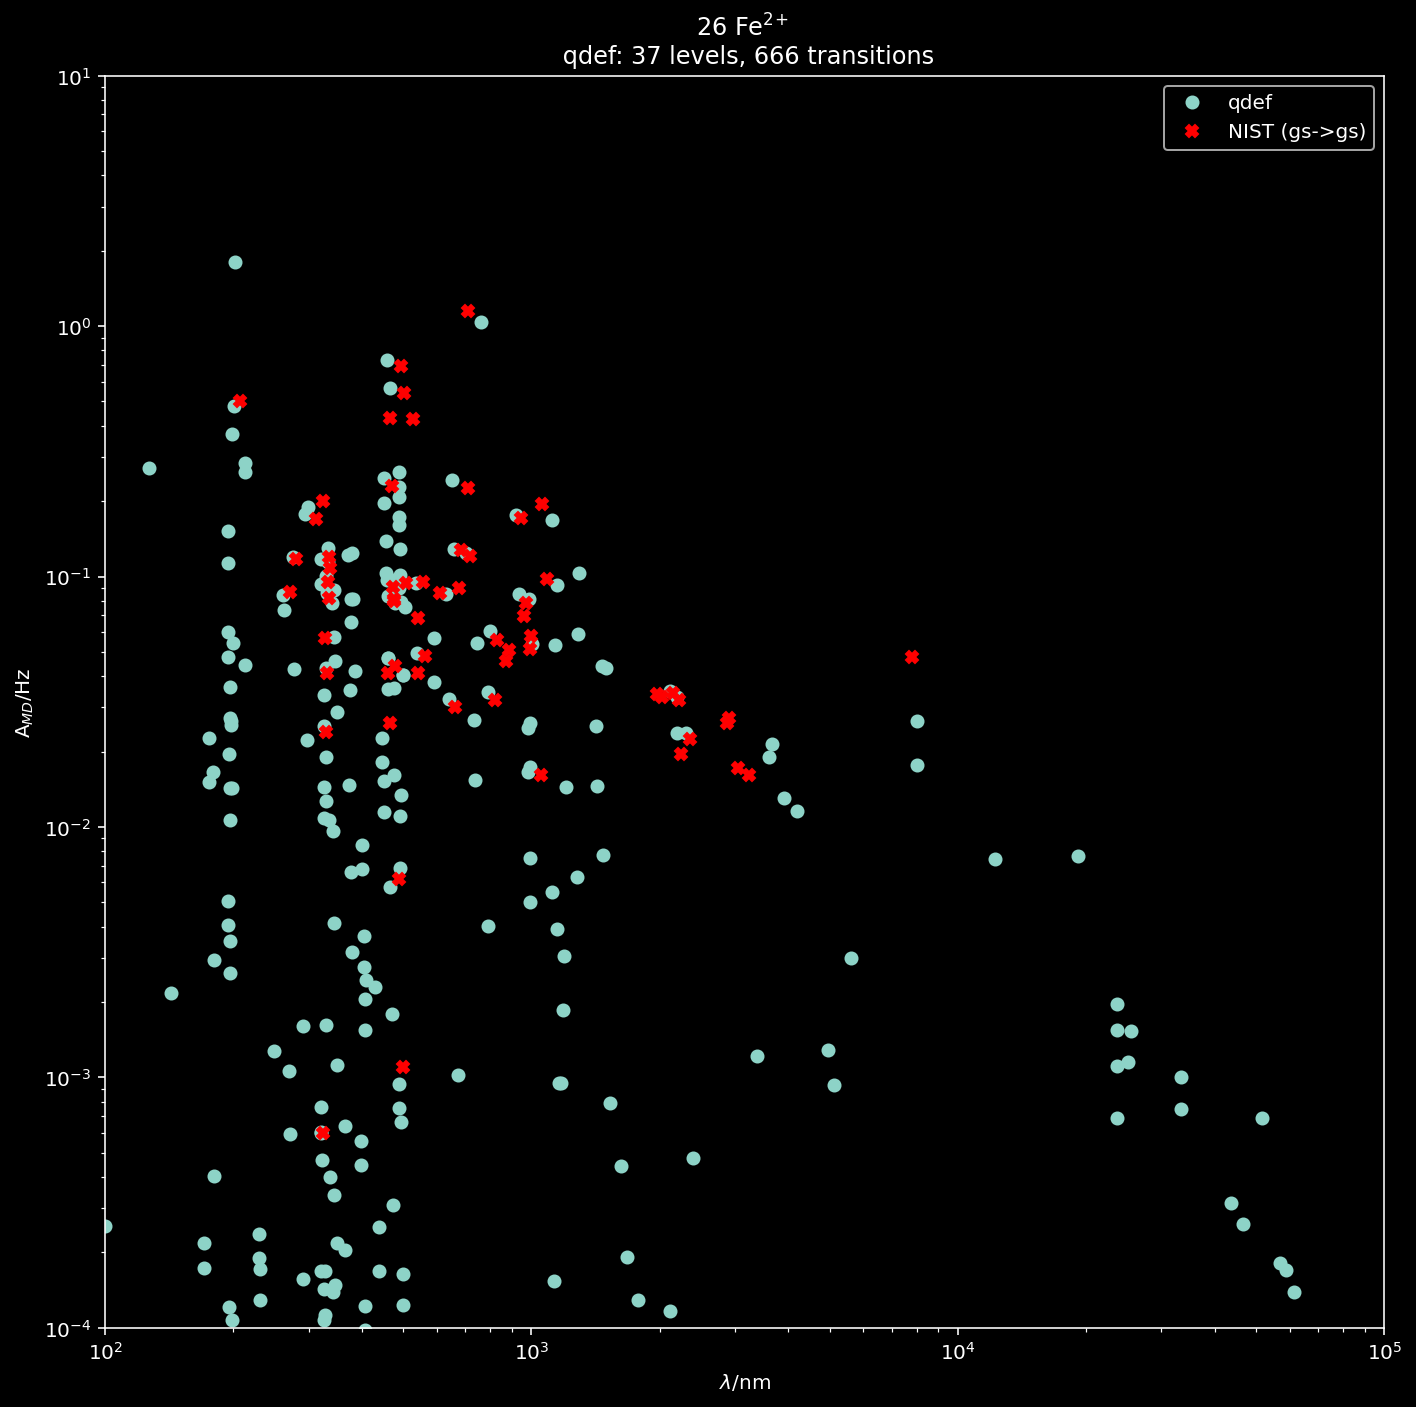

In [309]:
# given a list of energies, and an associated array of vectors
# determine which groups have the same energy to a given tolerance
# and keep a single representative eigenvector together with the degeneracy
# the result should be a list of dictionaries
# each of which has three keys: energy, degeneracy, qet

tolerance = 6
nonz = list((free_ion_data['Energy Levels / cm^{-1}'].apply(lambda x:len(x)!=0)))
nonz = [idx for idx in range(len(free_ion_data)) if nonz[idx]]
average_transition_plot = True
index = 26

# grab the row for this ion
row = free_ion_data.iloc[index]
# instantiate Ion with additional properties
ion =  Ion(row['Ion'], row['charge'])
# num electrons
num_electrons = row['N']
# energies with uncertainties
raw_energies = row['Energy Levels / cm^{-1}'] * UnitCon.con_factor('cm^{-1}','eV')
# strip away the uncertainty
energies = [x.nominal_value for x in raw_energies]
# turn into array with given tolerance
energies_array = np.round(energies,tolerance)
# determine the indices of equal energies
uenergies, uindices, degeneracies = np.unique(energies_array, return_index=True, return_counts=True)
# aggregate all levels in this list
levels = []
# eigenstates in rows
eigenstates = row['Eigenvectors']
for uenergy, g, uindex in zip(uenergies, degeneracies, uindices):
    level = {}
    level['energy'] = raw_energies[uindex]
    level['g'] = g
    level['index_mask'] = (energies_array == uenergy)
    chosen_eigenstates = eigenstates[energies_array == uenergy]
    rounded_eigenstates = []
    for eigenstate in chosen_eigenstates:
            eigenstate[np.abs(eigenstate)<1e-10] = 0
            norm = np.sqrt(np.sum(np.abs(eigenstate)**2))
            eigenstate = eigenstate/norm
            rounded_eigenstates.append(eigenstate)
    level['eigenvectors'] = np.array(rounded_eigenstates).T
    levels.append(level)

gs_conf = Ion(row['Ion'], row['charge']).nist_data_levels['Configuration'][0]
uenergies = np.array(uenergies)
ion_symbol = '%s${}^{%d\!+}$' % (row['Ion'], row['charge'])
mag_dip_s = standard_mag_dip(num_electrons, 2)[0]
mag_dip_s = {axis: np.array(mat.subs({sp.Symbol('g_s', real=True): Con.gs}), 
                            dtype=np.complex64) 
                for axis, mat in mag_dip_s.items()}

# eigenstates in columns
eigenstates = eigenstates.T

this_mag_dip = {}
for axis in mag_dip_s:
    this_mag_dip[axis] = np.matmul(np.matmul(np.conjugate(eigenstates.T), mag_dip_s[axis]), eigenstates)

this_mag_dip_array = np.array([this_mag_dip[axis] for axis in 'xyz'])

Smatrix = sum([np.abs(this_mag_dip[axis])**2 for axis in this_mag_dip])

# find all the differences in energy between all the level energies
ΔE = np.subtract.outer(energies_array, energies_array)
# set the diagonal to nan
ΔE[ΔE == 0] = np.nan
# calculate the wavelengths in m
Δλ = (UnitCon.hc/ΔE) * UnitCon.con_factor('nm','m') # wavelength is initially in nm, convert it to m

# determine the magnetic dipole transition rate matrix
A_MD = 16 * Con.π**3 * Con.μ0 * Con.μB**2 / 3 / Con.h / (Δλ**3) * Smatrix
A_MD = np.abs(A_MD)

average_transitions = []
for idx0, level0 in enumerate(levels):
    energy0 = level0['energy']
    g0 = level0['g']
    mask0 = level0['index_mask']
    level0['transitions'] = []
    for idx1, level1 in enumerate(levels):
        if idx0 == idx1:
            continue
        energy1 = level1['energy']
        wavelength = (UnitCon.hc / (energy0-energy1)) * UnitCon.con_factor('nm','m')
        if wavelength < 0:
            continue
        mask1 = level1['index_mask']
        dipole_ω = (energy0-energy1)/Con.ħ * UnitCon.con_factor('eV','J')
        masked_dipoles = [this_mag_dip[axis][mask0].T[mask1] for axis in 'xyz']
        dipole_vects = np.array(masked_dipoles)[:,:,0].T
        # pick all the matrix elements that correspond to the transition between
        # these two terms
        totalA_MD = np.sum(A_MD[mask0].T[mask1])/g0
        level0['transitions'].append({'angular_frequency_in_rad_per_second': dipole_ω,
                                      'dipole_vects_in_μB_units': dipole_vects, 
                                      'final_energy_in_eV': level1['energy'], 
                                      'initial_energy_in_eV': level0['energy'],
                                      'total_average_rate': totalA_MD})
        transition = {'level_i': level0, 'level_f': level1, 'rate/Hz': totalA_MD, 'wavelength/m': wavelength}
        average_transitions.append(transition)

# ΔJ = list(map(lambda x: '($%s$ nm)\n%d ⇒ %d' % ('{:f}'.format(x['wavelength/m']*1e9), (x['level_i']['g']), (x['level_f']['g'])), average_transitions))


lines = ion.nist_data_lines[ion.nist_data_lines['Type'] == 'M1']

wave_path = 'kurvits2016/%s/%d/transition_rates/wavelength_in_nm' % (ion.symbol, num_electrons)
ostrength_path = 'kurvits2016/%s/%d/transition_rates/trans_rate_in_Hz' % (ion.symbol, num_electrons)
plt.figure(figsize=(10,10))
x = list(map(lambda x: x['wavelength/m'].nominal_value*1e9, average_transitions))
y = list(map(lambda x: x['rate/Hz'], average_transitions))
plt.plot(x, y,'o', label='qdef')

if len(lines) > 0:
    within = (lines['conf_i'] == gs_conf) & (lines['conf_k'] == gs_conf)
    if sum(within)>0:
        plt.plot(lines['ritz_wl_vac(nm)'][within], lines['Aki(s^-1)'][within],'rX',label='NIST (gs->gs)')
    if len(within) != sum(within):
        plt.plot(lines['ritz_wl_vac(nm)'][~within], lines['Aki(s^-1)'][~within],'gX',label='NIST ~(gs->gs)')
plt.xlabel('$\\lambda$/nm')
plt.ylabel('A${}_{MD}$/Hz')
plt.xscale('log')
plt.yscale('log')
# try:
#     jonx, jony = np.array(h5_file[wave_path]), np.array(h5_file[ostrength_path])
#     plt.plot(jonx,jony,'y3',label='Kurvits')
# except:
#     pass
plot_title = '{index} {ion_symb} \n qdef: {num_levels} levels, {num_transitions} transitions'.format(index = index, 
        ion_symb = ion_symbol, num_levels = len(levels), num_transitions = len(average_transitions))
plt.title(plot_title)
plt.ylim(10**(-4), max(10**np.ceil(log10(np.max(y))), 10**np.ceil(log10(np.max(lines['Aki(s^-1)'])))))
plt.xlim(10**2,10**5)
plt.legend()
plt.tight_layout()
# plt.savefig('%s-%d-%d.png' % (row['Ion'], row['charge'], index))
plt.show()


counter = 0
arrows = []
min_rate = 1e-5

max_counter = 0
max_level = 0
for level in levels:
    level_energy = level['energy'].nominal_value
    for transition in level['transitions']:
        final_energy = transition['final_energy_in_eV']
        λ = (UnitCon.hc / (level_energy-final_energy)) * UnitCon.con_factor('nm','m')
        if transition['total_average_rate'] < min_rate:
            continue
        arrows.append((level_energy, final_energy, transition['total_average_rate'], λ * UnitCon.con_factor('m','nm')))
        max_counter += 1
        max_level = max(max_level, level_energy)

if average_transition_plot:
    arrows = sorted(arrows, key = lambda x: x[2])
    fig, ax = plt.subplots(figsize=(25,15/29*max_counter))
    ticks = range(1, int(max_level)+1)
    for arrow in arrows:
        pretty_num = ' $%s\,\,s^{-1}$ @ %.1f nm' % (latex_float(arrow[2]), arrow[3].nominal_value)
        pretty_num = pretty_num.replace('\\times 10^{0}','')
        ax.annotate(pretty_num,(arrow[1].nominal_value, counter), 
                    xytext = (arrow[0], counter), 
                    verticalalignment='center', 
                    arrowprops = dict(color='w',width=0.5,headwidth=2), 
                    bbox=dict(boxstyle="sawtooth,pad=0.3", fc="black", ec="w", lw=1))
        if counter % 10 == 0 and counter > 0:
            for tick in ticks:
                ax.text(tick, counter+0.5, str(tick), ha='center', size=5, alpha=0.2)
            # ax.plot(ticks, [counter+0.5]*len(ticks),'w|')
        counter += 1
    else:
        counter += -1
    for tick in ticks:
        plt.plot([tick,tick],[0,max_counter],'w:', alpha=0.2, lw=0.5)
    for level in levels:
        level_energy = level['energy'].nominal_value
        ax.plot([level_energy,level_energy],[0,max_counter])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_xlabel('E/eV')
    ax.set_ylim(-1,max_counter+1)
    ax.set_title(plot_title)
    plt.tight_layout()
    plt.savefig('dummy.pdf', bbox_inches ='tight', pad_inches=1)
    plt.close()
else:
    counter = 0
    arrows = []
    min_rate = 1e-5

    max_counter = 0
    for level in levels:
        level_energy = level['energy'].nominal_value
        for transition in level['transitions']:
            final_energy = transition['final_energy_in_eV']
            λ = (UnitCon.hc / (level_energy-final_energy)) * UnitCon.con_factor('nm','m')
            for dip_squared in list(np.sum(np.abs(transition['dipole_vects_in_μB_units'])**2,axis=1)):
                transition_rate = 16 * Con.π**3 * Con.μ0 * Con.μB**2 / 3 / Con.h / λ**3 * dip_squared
                if transition_rate < min_rate:
                    continue
                arrows.append((level_energy, final_energy, transition_rate, λ * UnitCon.con_factor('m','nm')))
                max_counter += 1
    arrows = sorted(arrows, key = lambda x: x[2])
    fig, ax = plt.subplots(figsize=(25,15/29*max_counter))
    for arrow in arrows:
        pretty_num = ' $%s\,\,s^{-1}$ @ %.1f nm' % (latex_float(arrow[2].nominal_value), arrow[3].nominal_value)
        pretty_num = pretty_num.replace('\\times 10^{0}','')
        ax.annotate(pretty_num,(arrow[1].nominal_value, counter), 
                    xytext = (arrow[0]+0.025, counter), 
                    verticalalignment='center', 
                    arrowprops = dict(color='w',width=0.5,headwidth=2), 
                    bbox=dict(boxstyle="sawtooth,pad=0.3", fc="black", ec="w", lw=1))
        counter += 1
    else:
        counter += -1
    for level in levels:
        level_energy = level['energy'].nominal_value
        ax.plot([level_energy,level_energy],[0,max_counter])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_xlabel('E/eV')
    ax.set_ylim(-1,max_counter+1)
    ax.set_title(plot_title)
    plt.tight_layout()
    plt.savefig('dummy.pdf', bbox_inches ='tight', pad_inches=1)
    plt.close()

In [1]:
# import os
# def open_latest_pdf():
#     folder = '/Users/juan/Downloads/'
#     fnames = [os.path.join(folder,f) for f in os.listdir(folder)]
#     fnames = [(f, os.path.getmtime(f)) for f in fnames if ".pdf" in f]
#     fnames = sorted(fnames, key = lambda x: -x[1])
#     os.system('open "%s"' % fnames[0][0])


In [375]:
# transitions = []
# counter = 0
# for idx0, level0 in enumerate(levels):
#     energy0 = level0['energy']
#     g0 = level0['g']
#     mask0 = level0['index_mask']
#     for idx1, level1 in enumerate(levels):
#         counter += 1
#         if idx0 == idx1:
#             continue
#         energy1 = level1['energy']
#         wavelength = (UnitCon.hc / (energy0-energy1)) * UnitCon.con_factor('nm','m')
#         if wavelength < 0:
#             continue
#         mask1 = level1['index_mask']
#         # pick all the matrix elements that correspond to the transition between
#         # these two terms
#         totalA_MD = np.sum(A_MD[mask0].T[mask1])/g0
#         transition = {'level_i': level0, 'level_f': level1, 'rate/Hz': totalA_MD, 'wavelength/m': wavelength}
#         transitions.append(transition)

### Calculation across all ions from Table 1 in Morrison

#### Simple Plot

In [ ]:
# given a list of energies, and an associated array of vectors
# determine which groups have the same energy to a given tolerance
# and keep a single representative eigenvector together with the degeneracy
# the result should be a list of dictionaries
# each of which has three keys: energy, degeneracy, qet
tolerance = 6
nonz = list((free_ion_data['Energy Levels / cm^{-1}'].apply(lambda x:len(x)!=0)))
nonz = [idx for idx in range(len(free_ion_data)) if nonz[idx]]
for index in nonz:
    # grab the row for this ion
    row = free_ion_data.iloc[index]
    # instantiate Ion with additional properties
    ion =  Ion(row['Ion'], row['charge'])
    # num electrons
    num_electrons = row['N']
    # energies with uncertainties
    raw_energies = row['Energy Levels / cm^{-1}'] * UnitCon.con_factor('cm^{-1}','eV')
    # strip away the uncertainty
    energies = [x.nominal_value for x in raw_energies]
    # turn into array with given tolerance
    energies_array = np.round(energies,tolerance)
    # determine the indices of equal energies
    uenergies, uindices, degeneracies = np.unique(energies_array, return_index=True, return_counts=True)
    # aggregate all levels in this list
    levels = []
    # eigenstates in rows
    eigenstates = row['Eigenvectors']
    for uenergy, g, uindex in zip(uenergies, degeneracies, uindices):
        level = {}
        level['energy'] = raw_energies[uindex]
        level['g'] = g
        level['index_mask'] = (energies_array == uenergy)
        chosen_eigenstates = eigenstates[energies_array == uenergy]
        rounded_eigenstates = []
        for eigenstate in chosen_eigenstates:
                eigenstate[np.abs(eigenstate)<1e-10] = 0
                norm = np.sqrt(np.sum(np.abs(eigenstate)**2))
                eigenstate = eigenstate/norm
                rounded_eigenstates.append(eigenstate)
        level['eigenvectors'] = np.array(rounded_eigenstates).T
        levels.append(level)

    gs_conf = Ion(row['Ion'], row['charge']).nist_data_levels['Configuration'][0]
    uenergies = np.array(uenergies)
    plot_title = '%s${}^{%d+}$' % (row['Ion'], row['charge'])
    mag_dip_s = standard_mag_dip(num_electrons, 2)[0]
    mag_dip_s = {axis: np.array(mat.subs({sp.Symbol('g_s', real=True): Con.gs}), 
                                dtype=np.complex64) 
                    for axis, mat in mag_dip_s.items()}

    # eigenstates in columns
    eigenstates = eigenstates.T

    this_mag_dip = {}
    for axis in mag_dip_s:
        this_mag_dip[axis] = np.matmul(np.matmul(np.conjugate(eigenstates.T), mag_dip_s[axis]), eigenstates)
    
    Smatrix = sum([np.abs(this_mag_dip[axis])**2 for axis in this_mag_dip])

    # find all the differences in energy between all the level energies
    ΔE = np.subtract.outer(energies_array, energies_array)
    # set the diagonal to nan
    ΔE[ΔE == 0] = np.nan
    # calculate the wavelengths in m
    Δλ = (UnitCon.hc/ΔE) * UnitCon.con_factor('nm','m') # wavelength is initially in nm, convert it to m

    # determine the magnetic dipole transition rate matrix
    A_MD = 16 * Con.π**3 * Con.μ0 * Con.μB**2 / 3 / Con.h / (Δλ**3) * Smatrix
    A_MD = np.abs(A_MD)

    transitions = []
    for idx0, level0 in enumerate(levels):
        energy0 = level0['energy']
        g0 = level0['g']
        mask0 = level0['index_mask']
        for idx1, level1 in enumerate(levels):
            if idx0 == idx1:
                continue
            energy1 = level1['energy']
            wavelength = (UnitCon.hc / (energy0-energy1)) * UnitCon.con_factor('nm','m')
            if wavelength < 0:
                continue
            mask1 = level1['index_mask']
            # pick all the matrix elements that correspond to the transition between
            # these two terms
            totalA_MD = np.sum(A_MD[mask0].T[mask1])/g0
            transition = {'level_i': level0, 'level_f': level1, 'rate/Hz': totalA_MD, 'wavelength/m': wavelength}
            transitions.append(transition)

    ΔJ = list(map(lambda x: '($%s$ nm)\n%d ⇒ %d' % ('{:f}'.format(x['wavelength/m']*1e9), (x['level_i']['g']), (x['level_f']['g'])), transitions))


    lines = ion.nist_data_lines[ion.nist_data_lines['Type'] == 'M1']

    wave_path = 'kurvits2016/%s/%d/transition_rates/wavelength_in_nm' % (ion.symbol, num_electrons)
    ostrength_path = 'kurvits2016/%s/%d/transition_rates/trans_rate_in_Hz' % (ion.symbol, num_electrons)
    plt.figure(figsize=(10,10))
    x = list(map(lambda x: x['wavelength/m'].nominal_value*1e9, transitions))
    y = list(map(lambda x: x['rate/Hz'], transitions))
    plt.plot(x, y,'o', label='qdef')

    if len(lines) > 0:
        within = (lines['conf_i'] == gs_conf) & (lines['conf_k'] == gs_conf)
        if sum(within)>0:
            plt.plot(lines['ritz_wl_vac(nm)'][within], lines['Aki(s^-1)'][within],'rX',label='NIST (gs->gs)')
        if len(within) != sum(within):
            plt.plot(lines['ritz_wl_vac(nm)'][~within], lines['Aki(s^-1)'][~within],'gX',label='NIST ~(gs->gs)')
    plt.xlabel('$\\lambda$/nm')
    plt.ylabel('A${}_{MD}$/Hz')
    plt.xscale('log')
    plt.yscale('log')
    try:
        plt.plot(np.array(h5_file[wave_path]),
                np.array(h5_file[ostrength_path]),'y3',label='Kurvits')
    except:
        pass
    plt.title(str(index)+' : '+plot_title)
    plt.ylim(10**(-4), max(10**np.ceil(log10(np.max(y))), 10**np.ceil(log10(np.max(lines['Aki(s^-1)'])))))
    plt.xlim(10**2,10**5)
    plt.legend()
    plt.tight_layout()
    plt.savefig('%s-%d-%d.png' % (row['Ion'], row['charge'], index))
    plt.show()

#### Advanced Plotting

In [324]:
# given a list of energies, and an associated array of vectors
# determine which groups have the same energy to a given tolerance
# and keep a single representative eigenvector together with the degeneracy
# the result should be a list of dictionaries
# each of which has three keys: energy, degeneracy, qet

tolerance = 6
average_transition_plot = True
nonz = list((free_ion_data['Energy Levels / cm^{-1}'].apply(lambda x:len(x)!=0)))
nonz = [idx for idx in range(len(free_ion_data)) if nonz[idx]]
# all_transitions = {}
for index in nonz:
    if index in all_transitions:
        continue
    # grab the row for this ion
    row = free_ion_data.iloc[index]
    # instantiate Ion with additional properties
    ion =  Ion(row['Ion'], row['charge'])
    # num electrons
    num_electrons = row['N']
    # energies with uncertainties
    raw_energies = row['Energy Levels / cm^{-1}'] * UnitCon.con_factor('cm^{-1}','eV')
    # strip away the uncertainty
    energies = [x.nominal_value for x in raw_energies]
    # turn into array with given tolerance
    energies_array = np.round(energies,tolerance)
    # determine the indices of equal energies
    uenergies, uindices, degeneracies = np.unique(energies_array, return_index=True, return_counts=True)
    # aggregate all levels in this list
    levels = []
    # eigenstates in rows
    eigenstates = row['Eigenvectors']
    for uenergy, g, uindex in zip(uenergies, degeneracies, uindices):
        level = {}
        level['energy'] = raw_energies[uindex]
        level['g'] = g
        level['index_mask'] = (energies_array == uenergy)
        chosen_eigenstates = eigenstates[energies_array == uenergy]
        rounded_eigenstates = []
        for eigenstate in chosen_eigenstates:
                eigenstate[np.abs(eigenstate)<1e-10] = 0
                norm = np.sqrt(np.sum(np.abs(eigenstate)**2))
                eigenstate = eigenstate/norm
                rounded_eigenstates.append(eigenstate)
        level['eigenvectors'] = np.array(rounded_eigenstates).T
        levels.append(level)

    gs_conf = Ion(row['Ion'], row['charge']).nist_data_levels['Configuration'][0]
    uenergies = np.array(uenergies)
    ion_symbol = '%s${}^{%d\!+}$' % (row['Ion'], row['charge'])
    mag_dip_s = standard_mag_dip(num_electrons, 2)[0]
    mag_dip_s = {axis: np.array(mat.subs({sp.Symbol('g_s', real=True): Con.gs}), 
                                dtype=np.complex64) 
                    for axis, mat in mag_dip_s.items()}

    # eigenstates in columns
    eigenstates = eigenstates.T

    this_mag_dip = {}
    for axis in mag_dip_s:
        this_mag_dip[axis] = np.matmul(np.matmul(np.conjugate(eigenstates.T), mag_dip_s[axis]), eigenstates)

    this_mag_dip_array = np.array([this_mag_dip[axis] for axis in 'xyz'])

    Smatrix = sum([np.abs(this_mag_dip[axis])**2 for axis in this_mag_dip])

    # find all the differences in energy between all the level energies
    ΔE = np.subtract.outer(energies_array, energies_array)
    # set the diagonal to nan
    ΔE[ΔE == 0] = np.nan
    # calculate the wavelengths in m
    Δλ = (UnitCon.hc/ΔE) * UnitCon.con_factor('nm','m') # wavelength is initially in nm, convert it to m

    # determine the magnetic dipole transition rate matrix
    A_MD = 16 * Con.π**3 * Con.μ0 * Con.μB**2 / 3 / Con.h / (Δλ**3) * Smatrix
    A_MD = np.abs(A_MD)

    transitions = []
    for idx0, level0 in enumerate(levels):
        energy0 = level0['energy']
        g0 = level0['g']
        mask0 = level0['index_mask']
        level0['transitions'] = []
        for idx1, level1 in enumerate(levels):
            if idx0 == idx1:
                continue
            energy1 = level1['energy']
            wavelength = (UnitCon.hc / (energy0-energy1)) * UnitCon.con_factor('nm','m')
            if wavelength < 0:
                continue
            mask1 = level1['index_mask']
            dipole_ω = (energy0-energy1)/Con.ħ * UnitCon.con_factor('eV','J')
            masked_dipoles = [this_mag_dip[axis][mask0].T[mask1] for axis in 'xyz']
            dipole_vects = np.array(masked_dipoles)[:,:,0].T
            # pick all the matrix elements that correspond to the transition between
            # these two terms
            totalA_MD = np.sum(A_MD[mask0].T[mask1])/g0
            level0['transitions'].append({'angular_frequency_in_rad_per_second': dipole_ω,
                                        'dipole_vects_in_μB_units': dipole_vects, 
                                        'final_energy_in_eV': level1['energy'], 
                                        'initial_energy_in_eV': level0['energy'],
                                        'total_average_rate': totalA_MD})
            transition = {'level_i': level0, 'level_f': level1, 'rate/Hz': totalA_MD, 'wavelength/m': wavelength}
            transitions.append(transition)

    # ΔJ = list(map(lambda x: '($%s$ nm)\n%d ⇒ %d' % ('{:f}'.format(x['wavelength/m']*1e9), (x['level_i']['g']), (x['level_f']['g'])), transitions))


    lines = ion.nist_data_lines[ion.nist_data_lines['Type'] == 'M1']

    wave_path = 'kurvits2016/%s/%d/transition_rates/wavelength_in_nm' % (ion.symbol, num_electrons)
    ostrength_path = 'kurvits2016/%s/%d/transition_rates/trans_rate_in_Hz' % (ion.symbol, num_electrons)
    plt.figure(figsize=(10,10))
    x = list(map(lambda x: x['wavelength/m'].nominal_value*1e9, transitions))
    y = list(map(lambda x: x['rate/Hz'], transitions))
    plt.plot(x, y,'o', label='qdef')

    if len(lines) > 0:
        within = (lines['conf_i'] == gs_conf) & (lines['conf_k'] == gs_conf)
        if sum(within)>0:
            plt.plot(lines['ritz_wl_vac(nm)'][within], lines['Aki(s^-1)'][within],'rX',label='NIST (gs->gs)')
        if len(within) != sum(within):
            plt.plot(lines['ritz_wl_vac(nm)'][~within], lines['Aki(s^-1)'][~within],'gX',label='NIST ~(gs->gs)')
    plt.xlabel('$\\lambda$/nm')
    plt.ylabel('A${}_{MD}$/Hz')
    plt.xscale('log')
    plt.yscale('log')
    # try:
    #     jonx, jony = np.array(h5_file[wave_path]), np.array(h5_file[ostrength_path])
    #     plt.plot(jonx,jony,'y3',label='Kurvits')
    # except:
    #     pass
    plot_title = '{ion_symb} MD Transition Rates \n {num_levels} levels, {num_transitions} transitions'.format(index = index, 
            ion_symb = ion_symbol, num_levels = len(levels), num_transitions = len(transitions))
    print(plot_title)
    plt.title(plot_title)
    plt.ylim(10**(-4), max(10**np.ceil(log10(np.max(y))), 10**np.ceil(log10(np.max(lines['Aki(s^-1)'])))))
    plt.xlim(10**2,10**5)
    plt.legend()
    plt.tight_layout()
    # plt.savefig('%s-%d-%d.png' % (row['Ion'], row['charge'], index))
    plt.savefig('./FreeIonTRates/waveplot-%s-%d-%d.pdf' % (row['Ion'], row['charge'], index), bbox_inches ='tight', pad_inches=1)
    plt.close()


    counter = 0
    arrows = []
    min_rate = 1e-5

    max_counter = 0
    max_level = 0
    for level in levels:
        level_energy = level['energy'].nominal_value
        for transition in level['transitions']:
            final_energy = transition['final_energy_in_eV']
            λ = (UnitCon.hc / (level_energy-final_energy)) * UnitCon.con_factor('nm','m')
            if transition['total_average_rate'] < min_rate:
                continue
            arrows.append((level_energy, final_energy, transition['total_average_rate'], λ * UnitCon.con_factor('m','nm')))
            max_counter += 1
            max_level = max(max_level, level_energy)

    if average_transition_plot:
        arrows = sorted(arrows, key = lambda x: x[2])
        fig, ax = plt.subplots(figsize=(25,15/29*max_counter))
        ticks = range(1, int(max_level)+1)
        for arrow in arrows:
            pretty_num = ' $%s\,\,s^{-1}$ @ %.1f nm' % (latex_float(arrow[2]), arrow[3].nominal_value)
            pretty_num = pretty_num.replace('\\times 10^{0}','')
            ax.annotate(pretty_num,(arrow[1].nominal_value, counter), 
                        xytext = (arrow[0], counter), 
                        verticalalignment='center', 
                        arrowprops = dict(color='w',width=0.5,headwidth=2), 
                        bbox=dict(boxstyle="sawtooth,pad=0.3", fc="black", ec="w", lw=1))
            if counter % 10 == 0 and counter > 0:
                for tick in ticks:
                    ax.text(tick, counter+0.5, str(tick), ha='center', size=5, alpha=0.2)
                # ax.plot(ticks, [counter+0.5]*len(ticks),'w|')
            counter += 1
        else:
            counter += -1
        for tick in ticks:
            plt.plot([tick,tick],[0,max_counter],'w:', alpha=0.2, lw=0.5)
        for level in levels:
            level_energy = level['energy'].nominal_value
            ax.plot([level_energy,level_energy],[0,max_counter])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_xlabel('E/eV')
        ax.set_ylim(-1,max_counter+1)
        ax.set_title(plot_title)
        try:
            plt.tight_layout()
        except:
            pass
        plt.savefig('./FreeIonTRates/metrodiagram-%s-%d-%d.pdf' % (row['Ion'], row['charge'], index), bbox_inches ='tight', pad_inches=1)
        plt.close()
    else:
        counter = 0
        arrows = []
        min_rate = 1e-5

        max_counter = 0
        for level in levels:
            level_energy = level['energy'].nominal_value
            for transition in level['transitions']:
                final_energy = transition['final_energy_in_eV']
                λ = (UnitCon.hc / (level_energy-final_energy)) * UnitCon.con_factor('nm','m')
                for dip_squared in list(np.sum(np.abs(transition['dipole_vects_in_μB_units'])**2,axis=1)):
                    transition_rate = 16 * Con.π**3 * Con.μ0 * Con.μB**2 / 3 / Con.h / λ**3 * dip_squared
                    if transition_rate < min_rate:
                        continue
                    arrows.append((level_energy, final_energy, transition_rate, λ * UnitCon.con_factor('m','nm')))
                    max_counter += 1
        arrows = sorted(arrows, key = lambda x: x[2])
        fig, ax = plt.subplots(figsize=(25,15/29*max_counter))
        for arrow in arrows:
            pretty_num = ' $%s\,\,s^{-1}$ @ %.1f nm' % (latex_float(arrow[2].nominal_value), arrow[3].nominal_value)
            pretty_num = pretty_num.replace('\\times 10^{0}','')
            ax.annotate(pretty_num,(arrow[1].nominal_value, counter), 
                        xytext = (arrow[0]+0.025, counter), 
                        verticalalignment='center', 
                        arrowprops = dict(color='w',width=0.5,headwidth=2), 
                        bbox=dict(boxstyle="sawtooth,pad=0.3", fc="black", ec="w", lw=1))
            counter += 1
        else:
            counter += -1
        for level in levels:
            level_energy = level['energy'].nominal_value
            ax.plot([level_energy,level_energy],[0,max_counter])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_xlabel('E/eV')
        ax.set_ylim(-1,max_counter+1)
        ax.set_title(plot_title)
        try:
            plt.tight_layout()
        except:
            pass
        plt.savefig('./FreeIonTRates/metrodiagram-%s-%d-%d.pdf' % (row['Ion'], row['charge'], index) , bbox_inches ='tight', pad_inches=1)
        plt.close()
    all_transitions[index] = transitions

Mn${}^{3\!+}$ MD Transition Rates 
 51 levels, 1275 transitions


/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/tight_bbox.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/tight_bbox.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/patches.py:744: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/transforms.py:2053: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty


Mn${}^{4\!+}$ MD Transition Rates 
 21 levels, 210 transitions
Mn${}^{4\!+}$ MD Transition Rates 
 20 levels, 190 transitions
Fe${}^{2\!+}$ MD Transition Rates 
 46 levels, 1035 transitions
Fe${}^{2\!+}$ MD Transition Rates 
 37 levels, 666 transitions
Fe${}^{2\!+}$ MD Transition Rates 
 35 levels, 595 transitions
Fe${}^{3\!+}$ MD Transition Rates 
 37 levels, 666 transitions
Fe${}^{4\!+}$ MD Transition Rates 
 36 levels, 630 transitions
Fe${}^{4\!+}$ MD Transition Rates 
 35 levels, 595 transitions
Co${}^{2\!+}$ MD Transition Rates 
 22 levels, 231 transitions
Co${}^{2\!+}$ MD Transition Rates 
 22 levels, 231 transitions
Co${}^{2\!+}$ MD Transition Rates 
 23 levels, 253 transitions
Co${}^{3\!+}$ MD Transition Rates 
 37 levels, 666 transitions
Co${}^{4\!+}$ MD Transition Rates 
 43 levels, 903 transitions
Ni${}^{2\!+}$ MD Transition Rates 
 12 levels, 66 transitions
Ni${}^{2\!+}$ MD Transition Rates 
 10 levels, 45 transitions
Ni${}^{2\!+}$ MD Transition Rates 
 11 levels, 55 transi

/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/tight_bbox.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/tight_bbox.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/patches.py:744: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/transforms.py:2053: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty


Zr${}^{2\!+}$ MD Transition Rates 
 9 levels, 36 transitions
Zr${}^{2\!+}$ MD Transition Rates 
 9 levels, 36 transitions
Nb${}^{2\!+}$ MD Transition Rates 
 26 levels, 325 transitions


/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/tight_bbox.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/tight_bbox.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/patches.py:744: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/transforms.py:2053: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty


Nb${}^{2\!+}$ MD Transition Rates 
 20 levels, 190 transitions
Nb${}^{3\!+}$ MD Transition Rates 
 9 levels, 36 transitions
Mo${}^{2\!+}$ MD Transition Rates 
 35 levels, 595 transitions
Mo${}^{2\!+}$ MD Transition Rates 
 50 levels, 1225 transitions


/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/tight_bbox.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/tight_bbox.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/patches.py:744: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/transforms.py:2053: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty


Mo${}^{3\!+}$ MD Transition Rates 
 20 levels, 190 transitions
Mo${}^{4\!+}$ MD Transition Rates 
 9 levels, 36 transitions
Tc${}^{2\!+}$ MD Transition Rates 
 23 levels, 253 transitions


/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/tight_bbox.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/tight_bbox.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/patches.py:744: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/transforms.py:2053: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty


Ru${}^{2\!+}$ MD Transition Rates 
 55 levels, 1485 transitions


/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/tight_bbox.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/tight_bbox.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/patches.py:744: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/transforms.py:2053: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty


Rh${}^{2\!+}$ MD Transition Rates 
 29 levels, 406 transitions


/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/tight_bbox.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/tight_bbox.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/patches.py:744: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/transforms.py:2053: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty


Rh${}^{2\!+}$ MD Transition Rates 
 20 levels, 190 transitions
Pd${}^{2\!+}$ MD Transition Rates 
 14 levels, 91 transitions


/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/tight_bbox.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/tight_bbox.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/patches.py:744: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/transforms.py:2053: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty


Pd${}^{2\!+}$ MD Transition Rates 
 10 levels, 45 transitions
Pd${}^{2\!+}$ MD Transition Rates 
 10 levels, 45 transitions
Pd${}^{3\!+}$ MD Transition Rates 
 22 levels, 231 transitions
Pd${}^{4\!+}$ MD Transition Rates 
 38 levels, 703 transitions
Ag${}^{3\!+}$ MD Transition Rates 
 14 levels, 91 transitions
Ag${}^{4\!+}$ MD Transition Rates 
 22 levels, 231 transitions
Cd${}^{4\!+}$ MD Transition Rates 
 10 levels, 45 transitions
Ta${}^{3\!+}$ MD Transition Rates 
 9 levels, 36 transitions
W${}^{2\!+}$ MD Transition Rates 
 34 levels, 561 transitions
W${}^{3\!+}$ MD Transition Rates 
 20 levels, 190 transitions
W${}^{4\!+}$ MD Transition Rates 
 9 levels, 36 transitions
Au${}^{3\!+}$ MD Transition Rates 
 10 levels, 45 transitions


In [313]:
!mkdir FreeIonTRates

In [316]:
!open .

In [325]:
!beep 

[autoreload of qdefcore failed: Traceback (most recent call last):
  File "/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/pandas/core/generic.py", line 1537, in __nonzero__
    raise ValueError(
ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
]

Reloading /Users/juan/ZiaLab/Codebase/qdef/data/CPGs.pkl ...


## Brik and Ma data from Cowan with Comparison to Kurvits

In [ ]:
import h5py

h5_file = h5py.File('/Users/juan/ZiaLab/Log/Data/kurvits_free_ion_data.h5','r')
list(h5_file.keys())
datum = np.array(h5_file['kurvits2016'])

In [12]:
brik = pickle.load(open('./data/brik_ma_cowan.pkl','rb'))

In [14]:
brik.to_hdf('./data/brik_ma_cowan.h5','brik')

In [15]:
!open .

In [8]:
brik[brik['Element'] == 'Cu']

Element  Charge  n  ndN   A/cm^-1  B/cm^-1  C/cm^-1      C/B  E_avg/cm^-1  \
8        Cu       2  3    9  217881.0  1377.37  5064.25  3.67676          NaN   
17       Cu       3  3    8  231739.0  1489.97  5528.84  3.71070     233721.0   
26       Cu       4  3    7  244510.0  1593.99  5962.13  3.74038     740003.0   
97       Cu       5  3    6  256456.0  1691.29  6370.18  3.76646    1552678.0   
106      Cu       6  3    5  267766.0  1783.30  6757.93  3.78957    2702481.0   
115      Cu       7  3    4  278577.0  1871.08  7129.17  3.81019    1687268.0   

     EI/cm^-1  ζd/cm^-1  r^2/Å^2  r^4/Å^4   Z  
8       38.94    830.74  0.29879  0.22192  29  
17      59.48    915.19  0.25289  0.14515  29  
26      82.60   1004.14  0.22041  0.10351  29  
97     108.03   1097.75  0.19596  0.07805  29  
106    135.55   1196.29  0.17673  0.06117  29  
115    165.03   1300.10  0.16107  0.04932  29

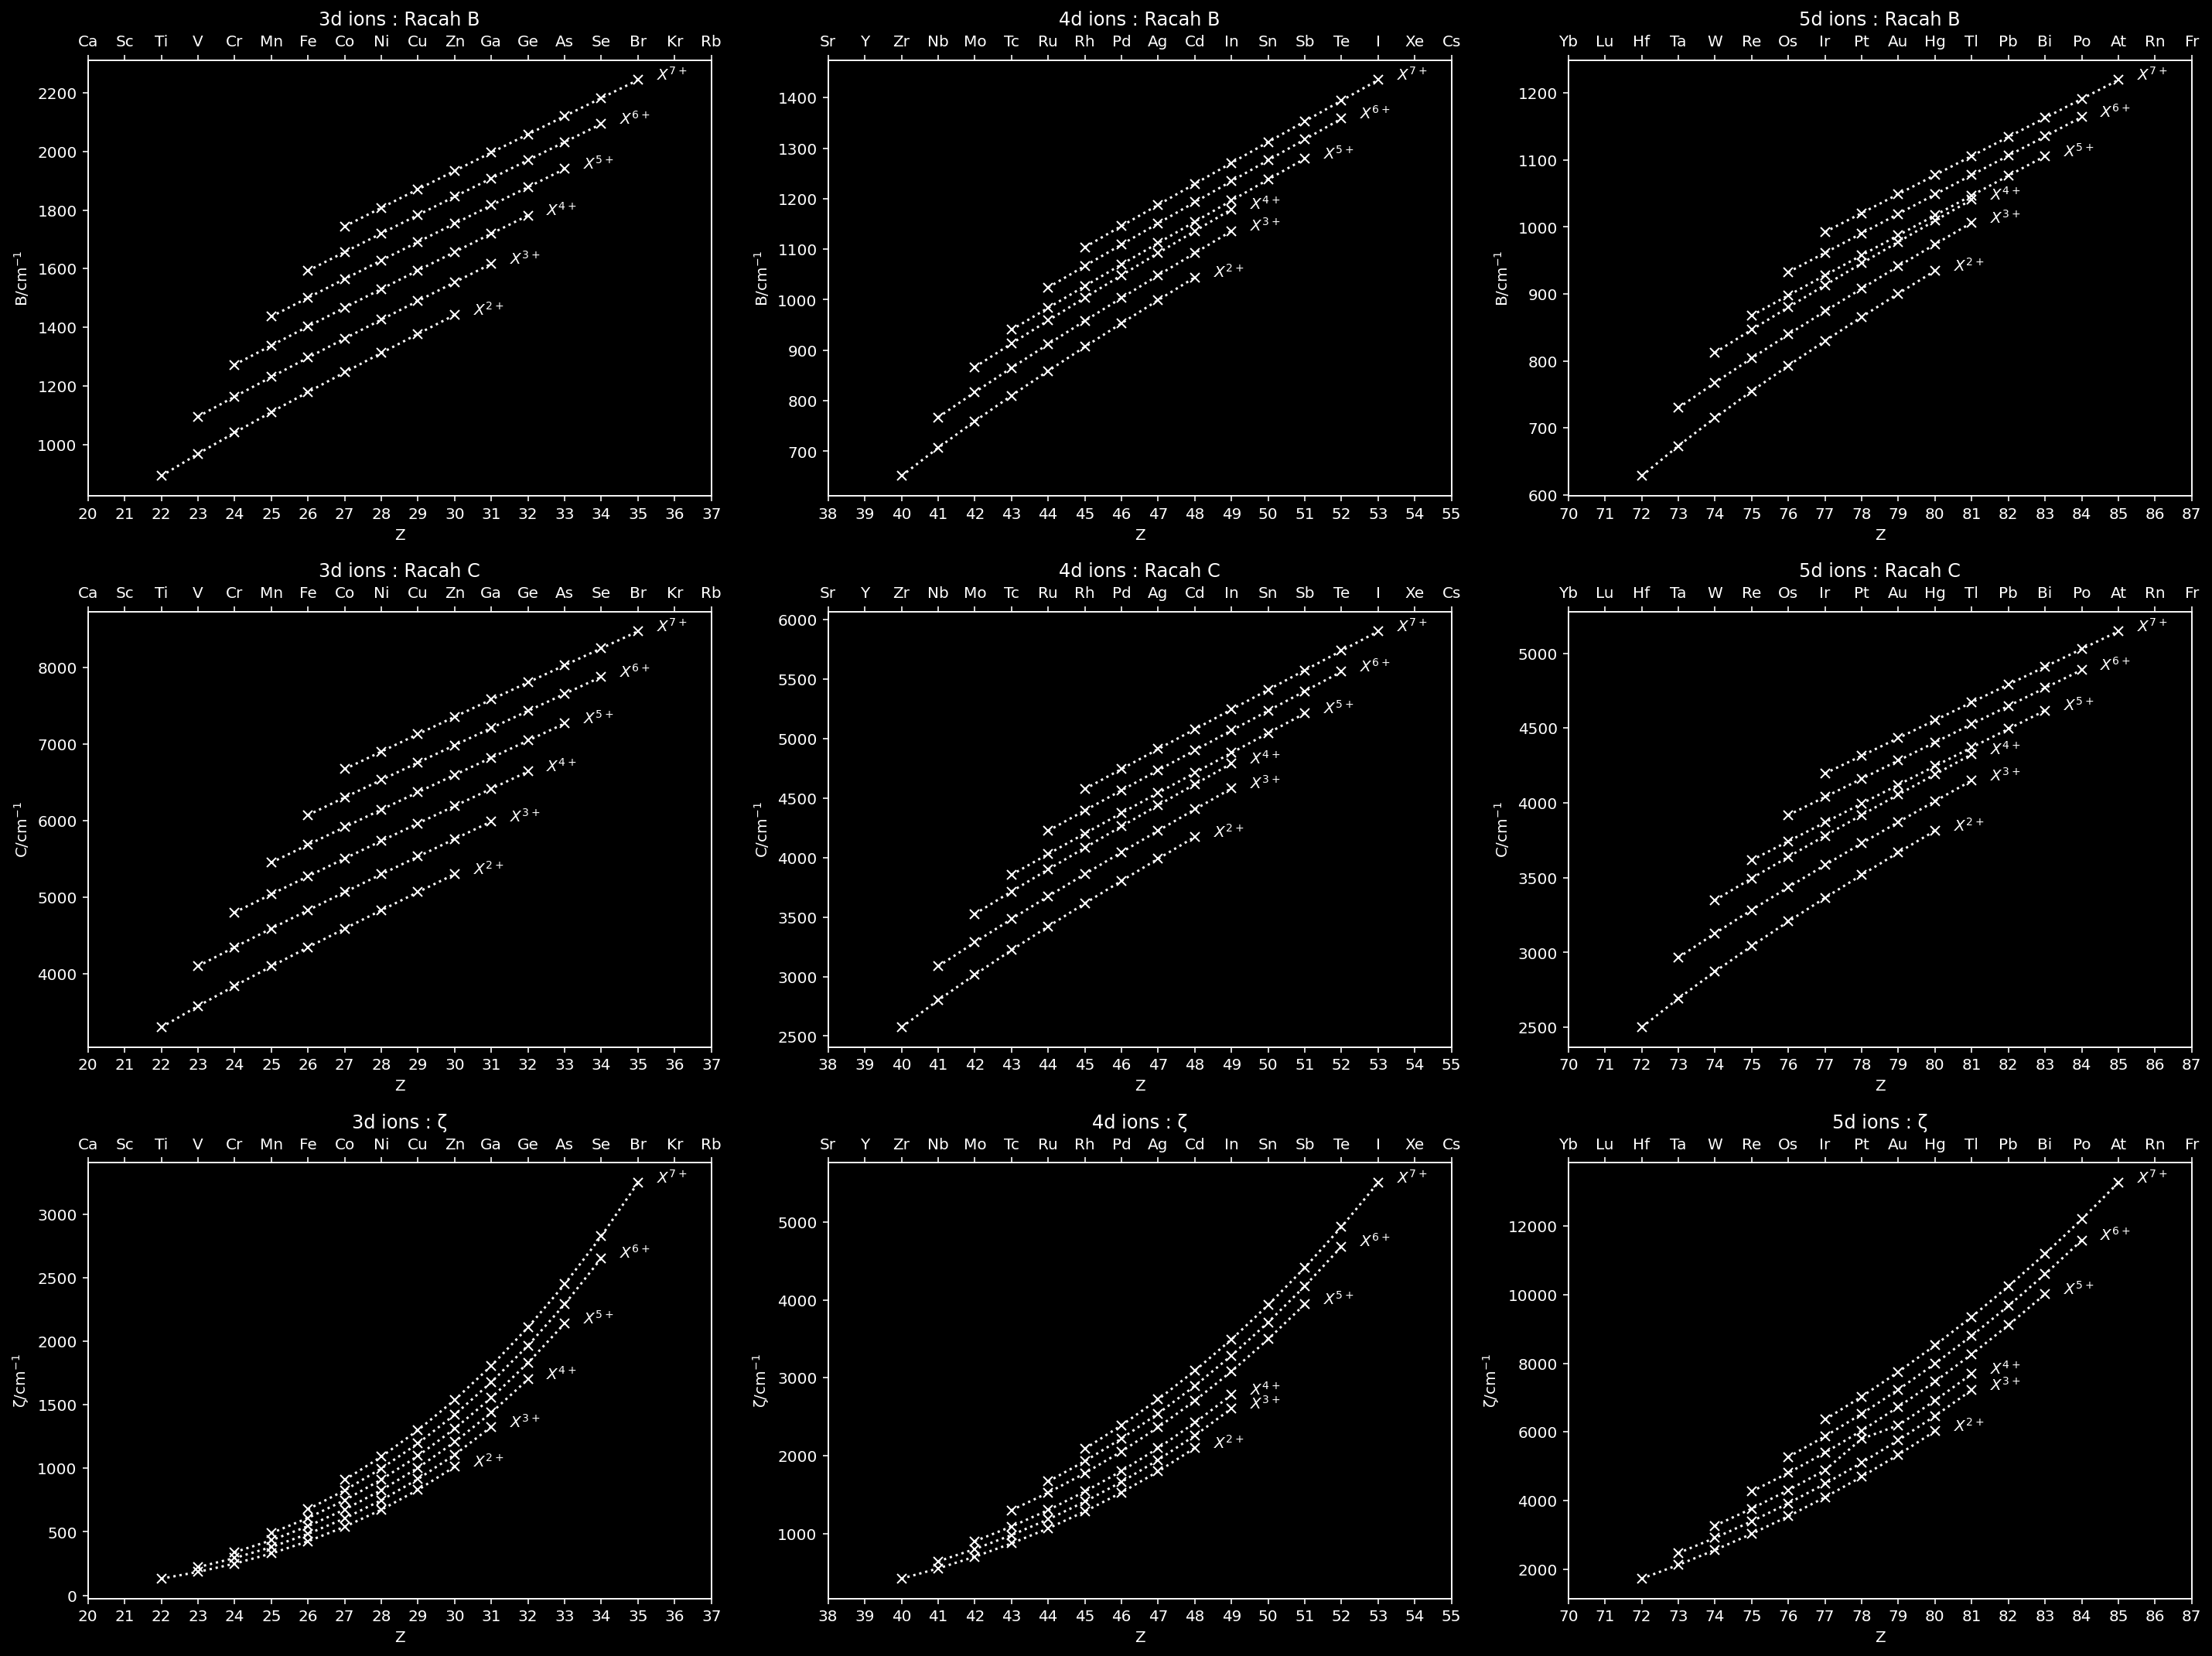

In [ ]:
fig, axes = plt.subplots(ncols = 3, nrows = 3, figsize = (20,10/2*3))
for col_idx, n in enumerate([3,4,5]):
    ax1 = axes[0][col_idx]
    ax1top = ax1.twiny()
    ax2 = axes[1][col_idx]
    ax2top = ax2.twiny()
    ax3 = axes[2][col_idx]
    ax3top = ax3.twiny()
    
    for charge_idx, charge in enumerate([2,3,4,5,6,7]):
        sub_brik = brik[(brik['n'] == n) & (brik['Charge'] == charge)]
        sub_brik = sub_brik[~sub_brik['A/cm^-1'].apply(np.isnan)]
        axlegend = '$X^{%d+}$' % (charge)
        ax1.plot(sub_brik['Z'], sub_brik['B/cm^-1'],'wx:',label=axlegend)
        ax1.text(np.max(sub_brik['Z'])+0.5, np.max(sub_brik['B/cm^-1']), axlegend, c='w')
        ax2.plot(sub_brik['Z'], sub_brik['C/cm^-1'], 'wx:', label = axlegend)
        ax2.text(np.max(sub_brik['Z'])+0.5, np.max(sub_brik['C/cm^-1']), axlegend, c='w')
        ax3.plot(sub_brik['Z'], sub_brik['ζd/cm^-1'], 'wx:', label = axlegend)
        ax3.text(np.max(sub_brik['Z'])+0.5, np.max(sub_brik['ζd/cm^-1']), axlegend, c='w')
    
    ax1.set_title('%dd ions : Racah B' % (n))
    ax2.set_title('%dd ions : Racah C' % (n))
    ax3.set_title('%dd ions : ζ' % (n))
    # ax3.set_yscale('log')

    xmin = {3:22,4:40,5:72}[n]
    xmax = {3:35,4:53,5:85}[n]
    xticks_labels = [num_to_symb[Z] for Z in range(xmin-2, xmax + 3)]

    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis='y', labelcolor='w')
        ax.set_xlabel('Z')
        ax.set_xticks(range(xmin-2, xmax + 3))

    ax1.set_ylabel('B/cm${}^{-1}$')
    ax2.set_ylabel('C/cm${}^{-1}$')
    ax3.set_ylabel('ζ/cm${}^{-1}$')

    
    for ax in [ax1top, ax2top, ax3top]:
        ax.set_xticks(range(xmin-2, xmax + 3), xticks_labels)
        ax.set_xlim(xmin-2, xmax + 2)

plt.tight_layout()
plt.show()

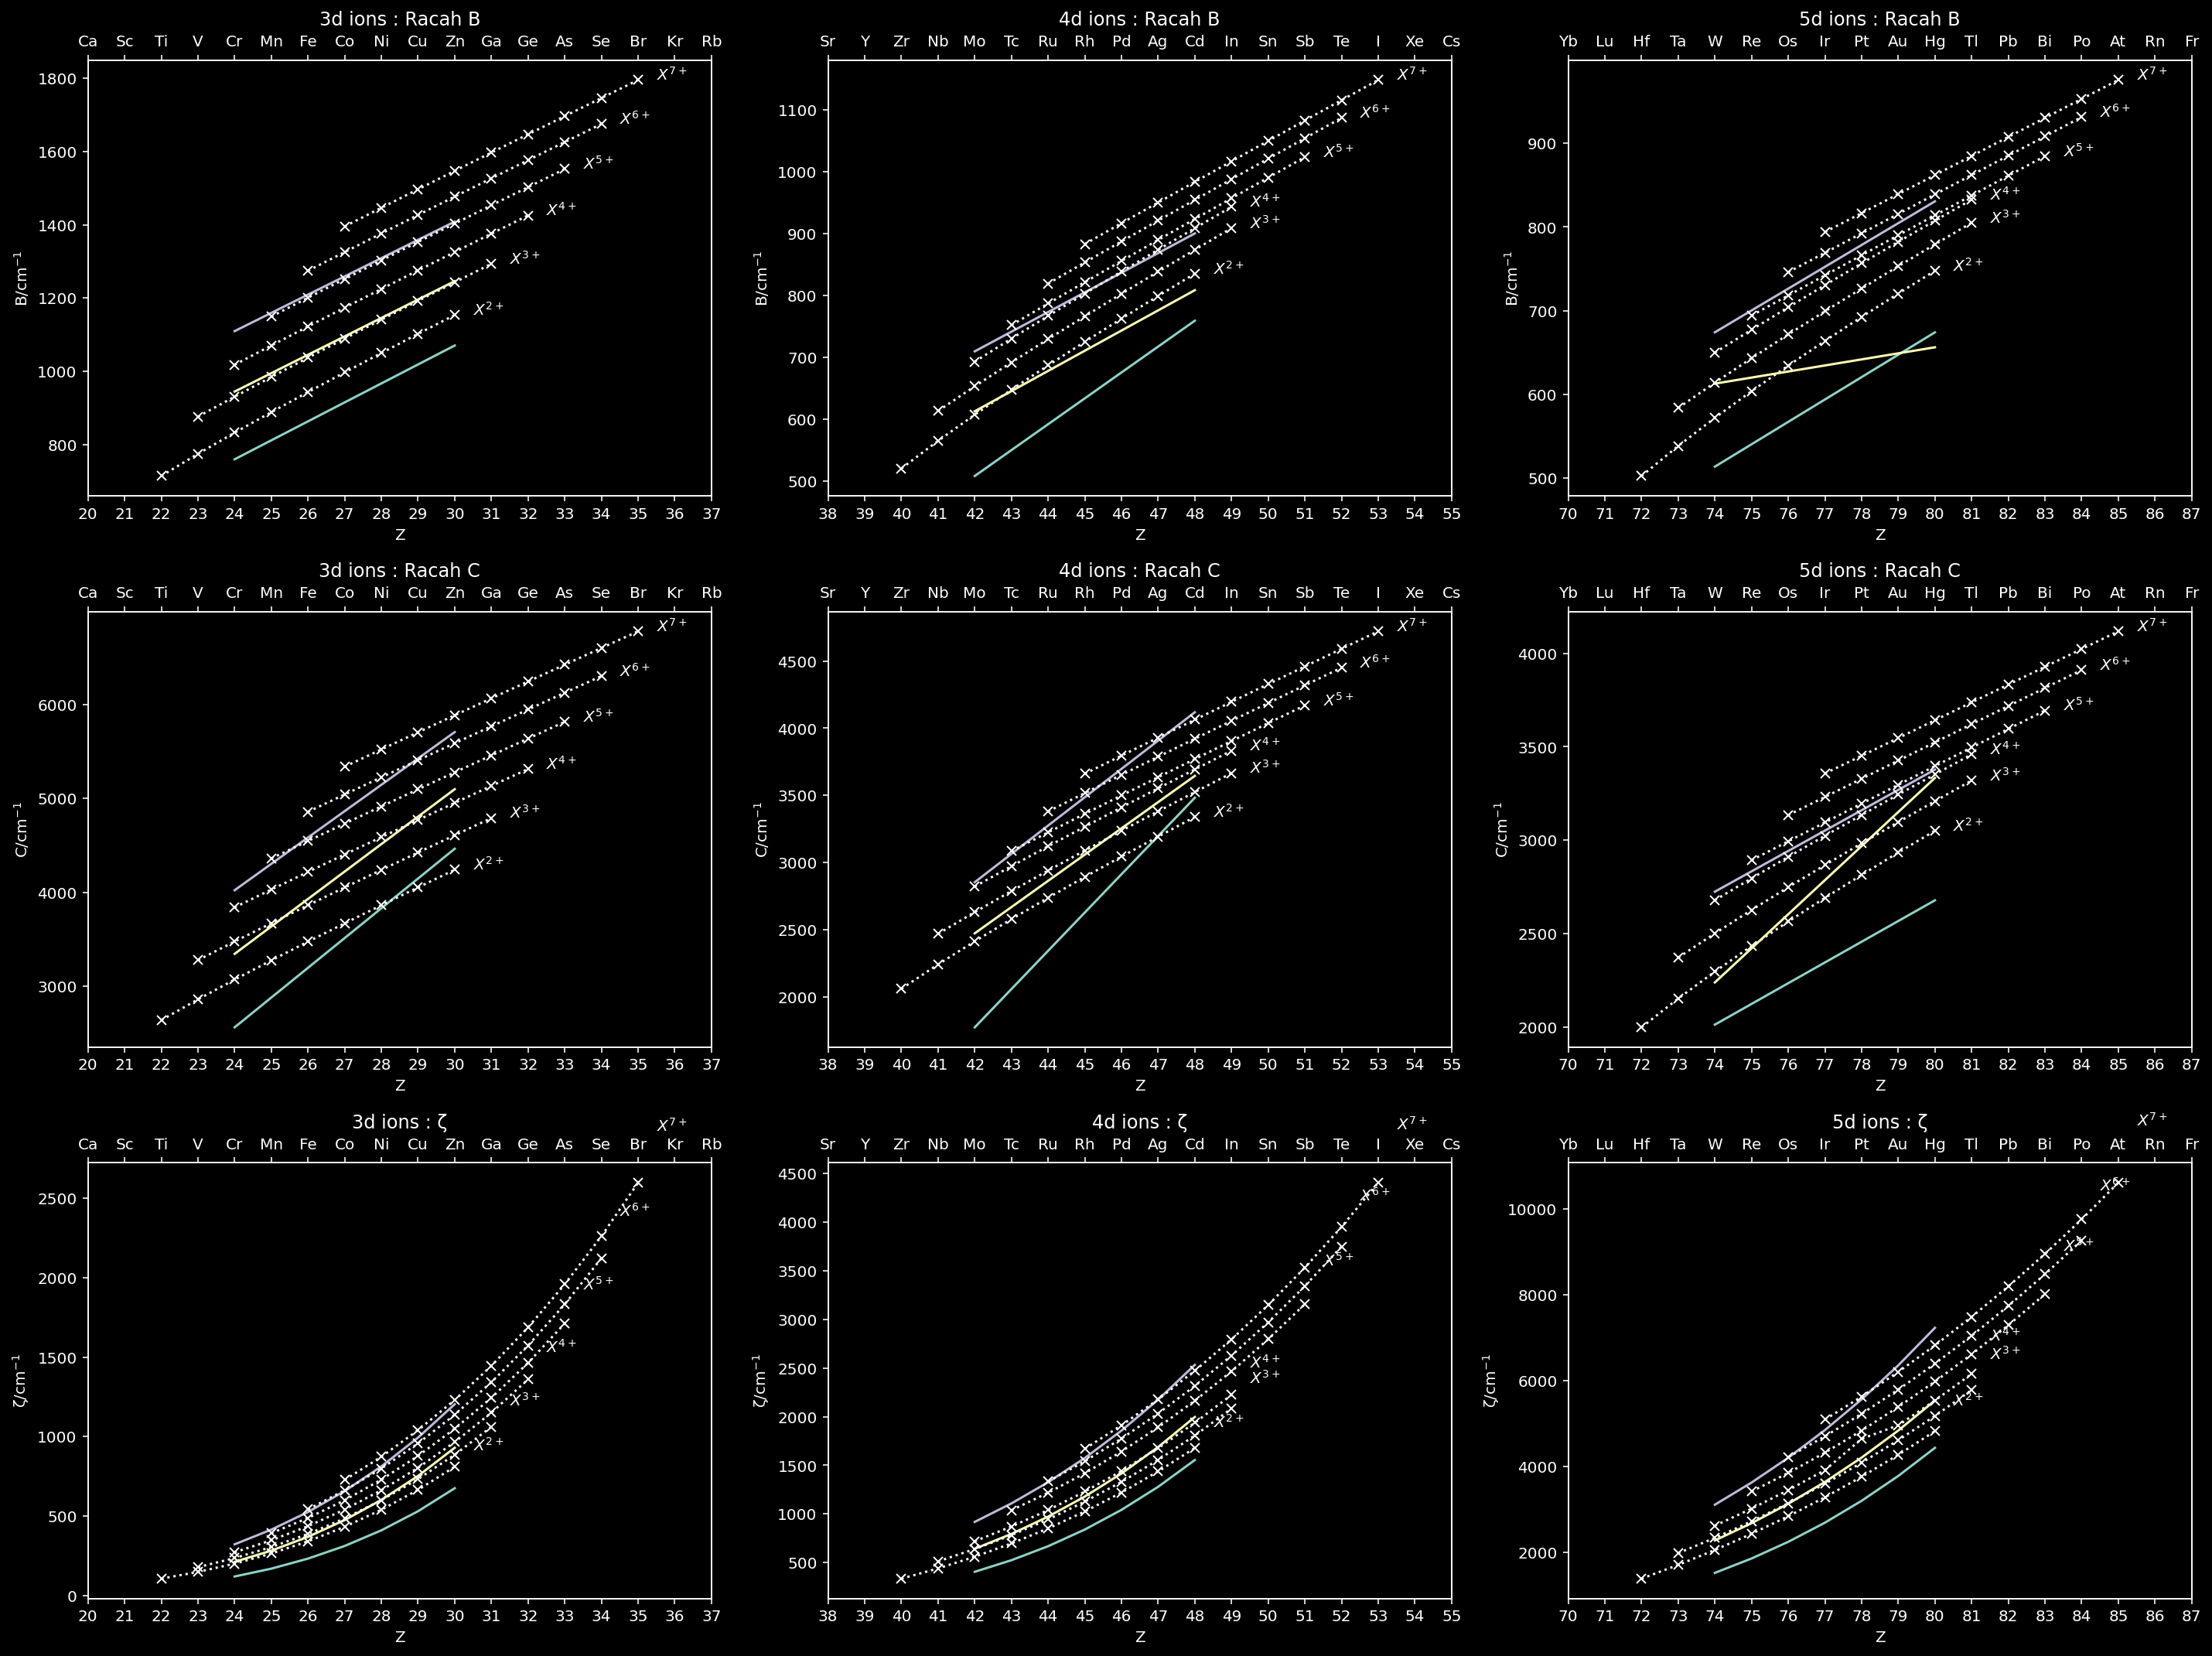

In [ ]:
fig, axes = plt.subplots(ncols = 3, nrows = 3, figsize = (20,10/2*3))
draw_kurvits = True
correction_factor = 0.8
correction_factor2 = 0.9
if not draw_kurvits:
    correction_factor = 1
    correction_factor2 = 1
for col_idx, n in enumerate([3,4,5]):
    ax1 = axes[0][col_idx]
    ax1top = ax1.twiny()
    ax2 = axes[1][col_idx]
    ax2top = ax2.twiny()
    ax3 = axes[2][col_idx]
    ax3top = ax3.twiny()
    config = '%dd' % n
    Zmin = {3:22,4:40,5:72}[n]
    num_valence_electrons_neutral = np.arange(2,9)
    Z_equiv = np.arange(2,9) + Zmin
    for charge_idx, charge in enumerate([2,3,4,5,6,7]):
        if draw_kurvits:
            try:
                Bparams = free_ion_fit_dict[("Bfit", config, charge)][-1::-1]
                Cparams = free_ion_fit_dict[("Cfit", config, charge)][-1::-1]
                SOparams = free_ion_fit_dict[("SOfit", config, charge)][-1::-1]
                Bees = np.polyval(Bparams,num_valence_electrons_neutral)
                Cees = np.polyval(Cparams,num_valence_electrons_neutral)
                ζees = np.polyval(SOparams,num_valence_electrons_neutral)
                ax1.plot(Z_equiv, Bees)
                ax2.plot(Z_equiv, Cees)
                ax3.plot(Z_equiv, ζees)
            except:
                pass
        sub_brik = brik[(brik['n'] == n) & (brik['Charge'] == charge)]
        sub_brik = sub_brik[~sub_brik['A/cm^-1'].apply(np.isnan)]
        axlegend = '$X^{%d+}$' % (charge)
        ax1.plot(sub_brik['Z'], correction_factor * sub_brik['B/cm^-1'],'wx:',label=axlegend)
        ax1.text(np.max(sub_brik['Z'])+0.5, correction_factor * np.max(sub_brik['B/cm^-1']), axlegend, c='w')
        ax2.plot(sub_brik['Z'], correction_factor * sub_brik['C/cm^-1'], 'wx:', label = axlegend)
        ax2.text(np.max(sub_brik['Z'])+0.5, correction_factor * np.max(sub_brik['C/cm^-1']), axlegend, c='w')
        ax3.plot(sub_brik['Z'], correction_factor * sub_brik['ζd/cm^-1'], 'wx:', label = axlegend)
        ax3.text(np.max(sub_brik['Z'])+0.5, correction_factor2 * np.max(sub_brik['ζd/cm^-1']), axlegend, c='w')
    
    ax1.set_title('%dd ions : Racah B' % (n))
    ax2.set_title('%dd ions : Racah C' % (n))
    ax3.set_title('%dd ions : ζ' % (n))
    # ax3.set_yscale('log')

    xmin = {3:22,4:40,5:72}[n]
    xmax = {3:35,4:53,5:85}[n]
    xticks_labels = [num_to_symb[Z] for Z in range(xmin-2, xmax + 3)]

    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis='y', labelcolor='w')
        ax.set_xlabel('Z')
        ax.set_xticks(range(xmin-2, xmax + 3))

    ax1.set_ylabel('B/cm${}^{-1}$')
    ax2.set_ylabel('C/cm${}^{-1}$')
    ax3.set_ylabel('ζ/cm${}^{-1}$')

    
    for ax in [ax1top, ax2top, ax3top]:
        ax.set_xticks(range(xmin-2, xmax + 3), xticks_labels)
        ax.set_xlim(xmin-2, xmax + 2)

plt.tight_layout()
plt.show()

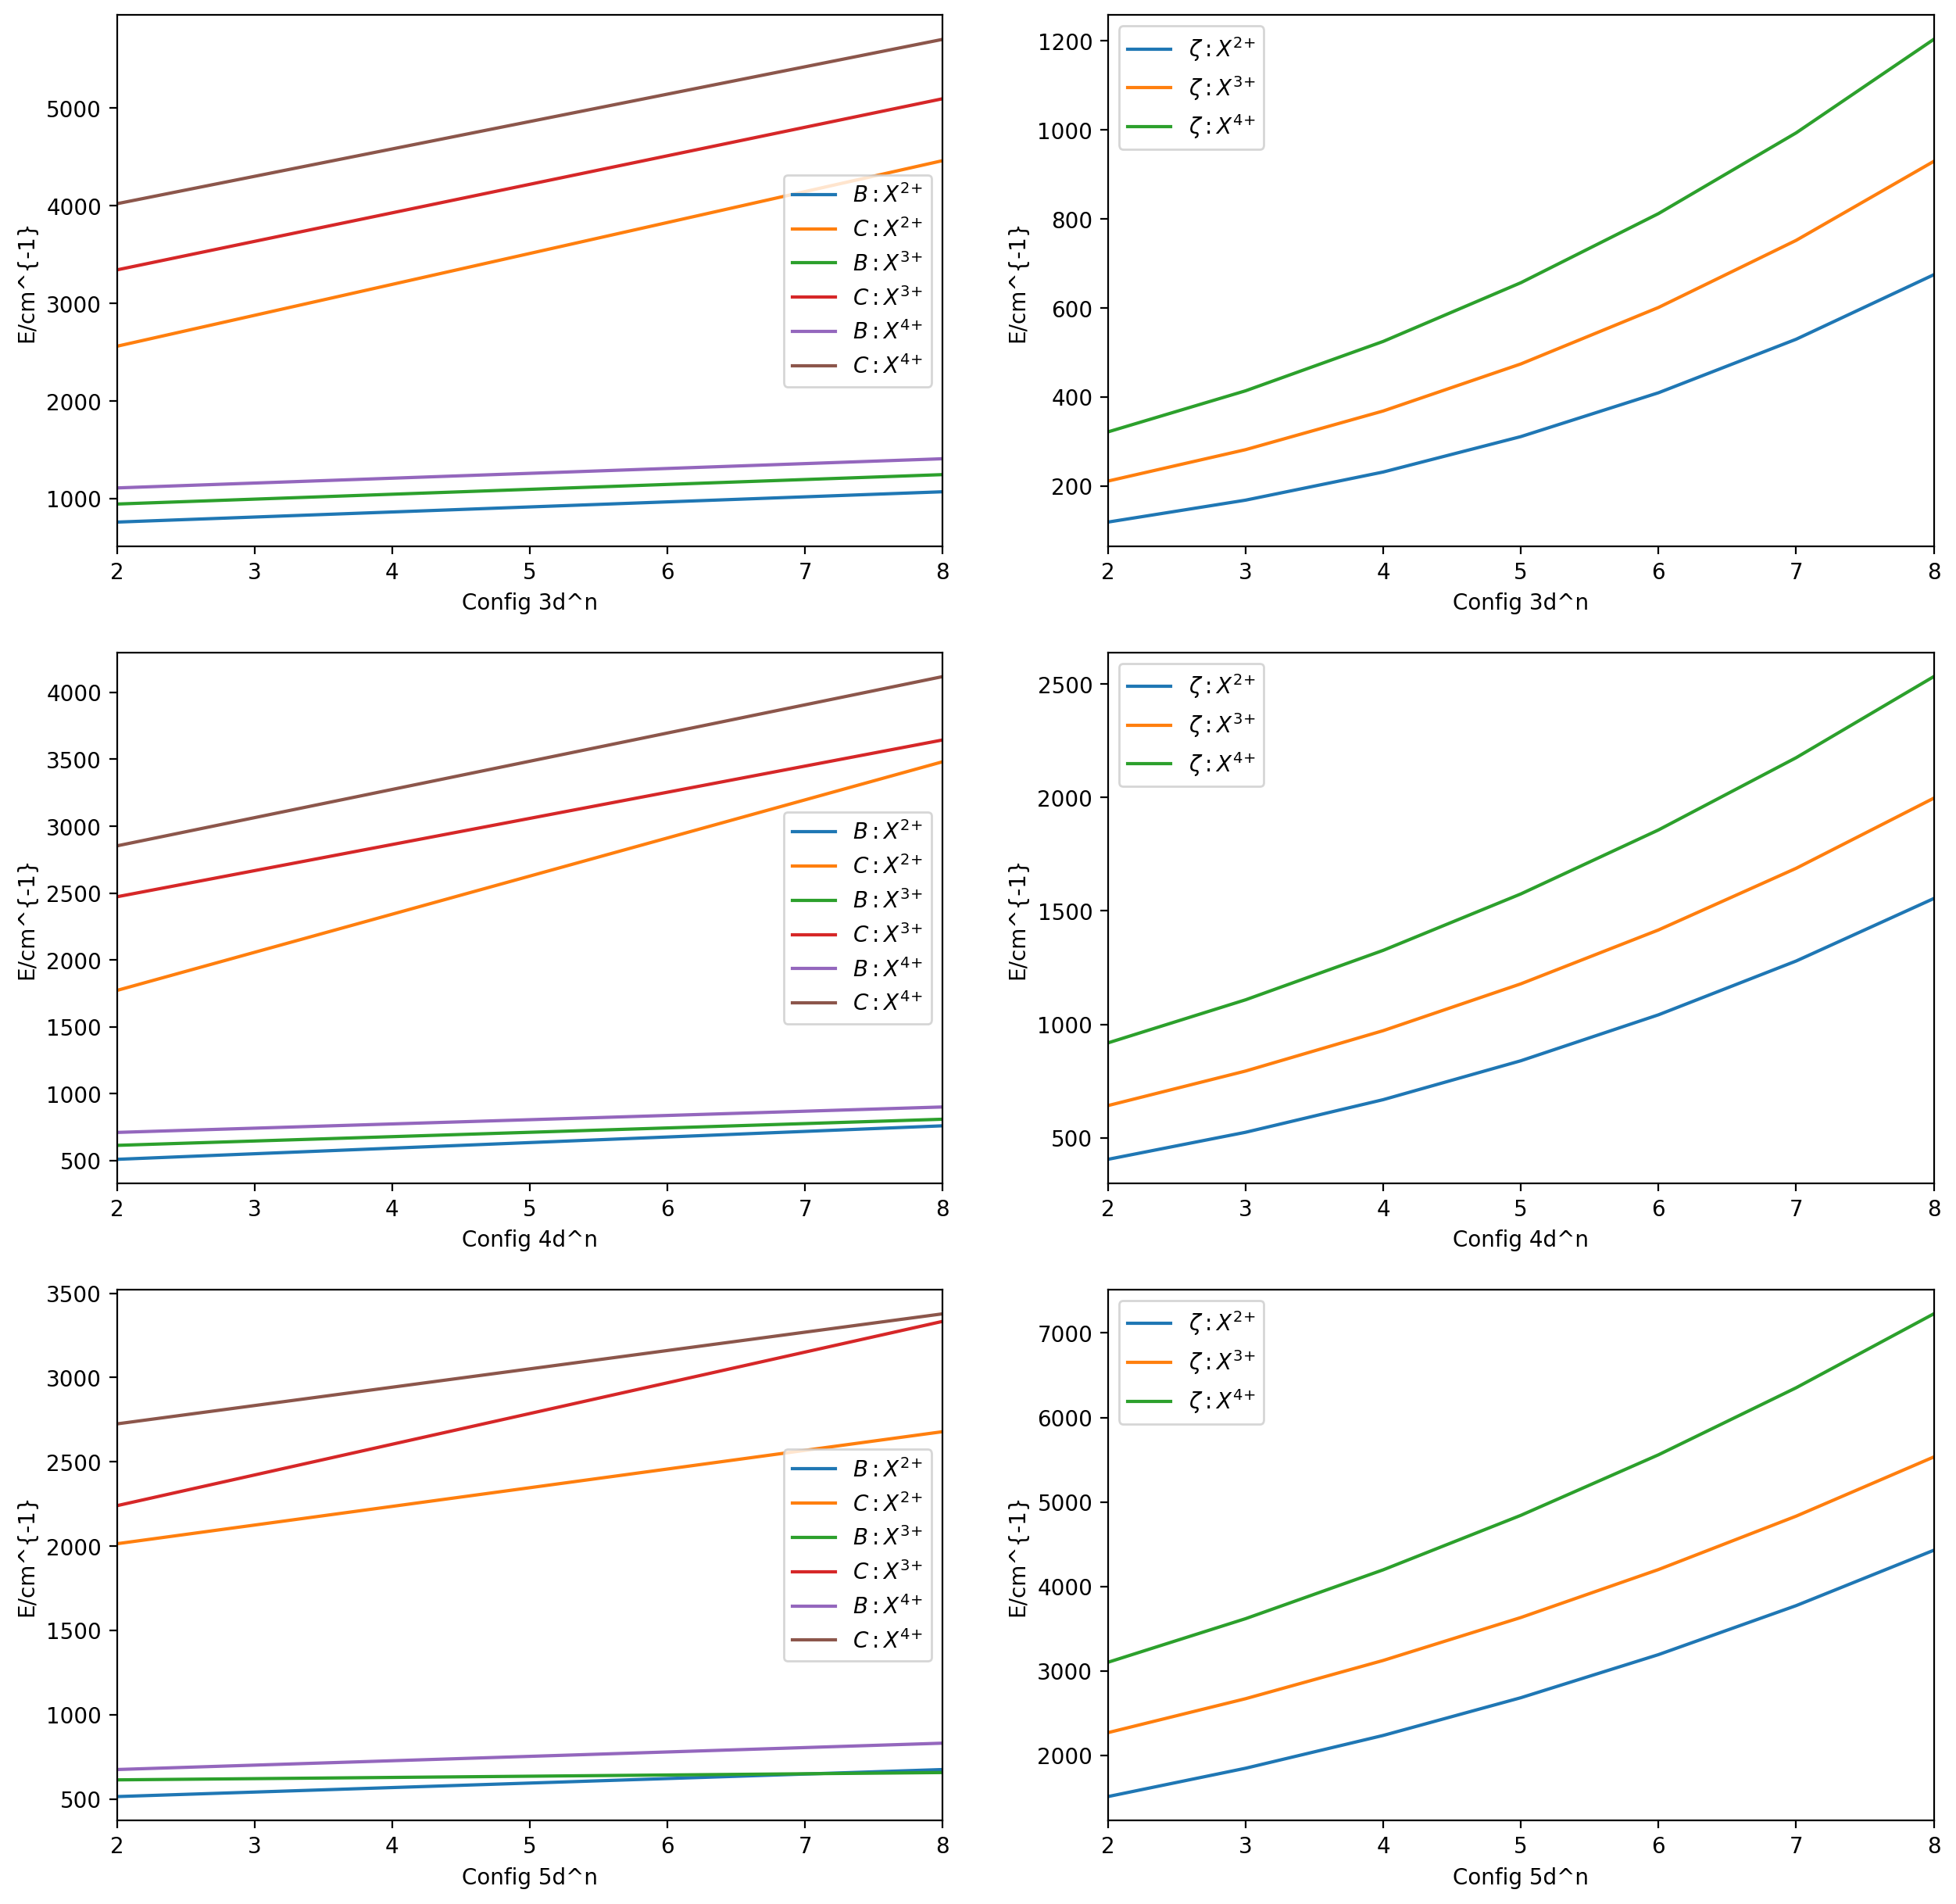

In [385]:
free_ion_fit_dict = {}
for fitType in ["Bfit","Cfit","SOfit"]:
    for config in ["3d","4d","5d"]:
        charges = list(h5_file['kurvits2016/fits/%s/%s/' % (fitType, config)])
        for charge in charges:
            free_ion_fit_dict[(fitType, config, int(charge))] = np.array(h5_file['kurvits2016/fits/%s/%s/%s' % (fitType, config, charge)])

subs = {sp.Symbol('F_{(4)}') : sp.Symbol('F^{(4)}')/441,
        sp.Symbol('F_{(0)}'): sp.Symbol('F^{(0)}'),
        sp.Symbol('F_{(2)}'): sp.Symbol('F^{(2)}')/49}
A = sp.Symbol('F_{(0)}') - 49 * sp.Symbol('F_{(4)}')
A = A.subs(subs)
B = sp.Symbol('F_{(2)}') - 5 * sp.Symbol('F_{(4)}')
B = B.subs(subs)
C = 35*sp.Symbol('F_{(4)}')
C = C.subs(subs)
slater_to_racah = sp.solve([sp.Symbol('A') - A, 
                        sp.Symbol('B') - B,
                        sp.Symbol('C') - C],
                        (sp.Symbol('F^{(0)}'), sp.Symbol('F^{(2)}'), sp.Symbol('F^{(4)}')))
racah_to_slater = sp.solve([sp.Symbol('A') - A, 
sp.Symbol('B') - B,
sp.Symbol('C') - C],
(sp.Symbol('A'), sp.Symbol('B'), sp.Symbol('C')))

# def fitted_slater_integrals(num_electrons, n):
num_valence_electrons_neutral = np.arange(2,9)
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(15,15))
for row_num, n in enumerate([3,4,5]):
    for charge in [2,3,4]:
        config = '%dd' % n
        Bparams = free_ion_fit_dict[("Bfit", config, charge)][-1::-1]
        Cparams = free_ion_fit_dict[("Cfit", config, charge)][-1::-1]
        SOparams = free_ion_fit_dict[("SOfit", config, charge)][-1::-1]
        Bees = np.polyval(Bparams,num_valence_electrons_neutral)
        Cees = np.polyval(Cparams,num_valence_electrons_neutral)
        ζees = np.polyval(SOparams,num_valence_electrons_neutral)
        for idx, y in enumerate([Bees, Cees, ζees]):
            label = '$%s: X^{%d\!+}$' % (["B","C","ζ"][idx], charge)
            col = 0
            if 'ζ' in label:
                col = 1
            axes[row_num][col].plot(num_valence_electrons_neutral, y, label=label)
for row_num  in [0,1,2]:
    for col_num in [0,1]:
        config = '%dd' % (row_num+3)
        ax = axes[row_num][col_num]
        ax.legend()
        ax.set_xlim(2,8)
        ax.set_xlabel('Config %s^n' % config)
        ax.set_ylabel('E/cm^{-1}')
plt.show()

In [386]:
kurvits_free_ion_fit_dict = free_ion_fit_dict

In [387]:
# pickle.dump(kurvits_free_ion_fit_dict, open('./data/kurvits_free_ion_fit_dict.pkl','wb'))

In [390]:
# # ADDED to qdef.py
# neutral_valence_electrons = 2
# n = 3
# charge = 2
# kurvits_free_ion_fit_dict = pickle.load(open('./data/kurvits_free_ion_fit_dict.pkl','rb'))
# SLATER_TO_RACAH = {sp.Symbol('F^{(0)}'): sp.Symbol('A') + sp.Symbol('C')*sp.S(7)/5,
#                    sp.Symbol('F^{(2)}'): 49*sp.Symbol('B') + 7*sp.Symbol('C'),
#                    sp.Symbol('F^{(4)}'): sp.Symbol('C')*sp.S(63)/5}
# def kurvits_slater_ints_and_SO(n:int, charge:int, neutral_valence_electrons:int) -> tuple:
#     '''
#     This  function  returns approximate values for the spin-orbit coupling
#     strength  ζ, and for the slater integrals F^{(2)} and F^{(4)} that may
#     be  used  to  approximate  the  interactions in free ions with valence
#     electrons in d-orbitals.
#     All given in energy units of cm^{-1}
#     Parameters
#     ----------
#     n (int)     : atom shell number (3,4,5)
#     charge (int): charge of positive ion (2,3,4)
#     neutral_valence_electrons  (int): valence electrons in neutral species
#                                       (2-8)
#     Returns
#     -------
#     F2, F4, ζ (tuple)
#     '''
#     config = '%dd' % n
#     Bparams = kurvits_free_ion_fit_dict[("Bfit", config, charge)][-1::-1]
#     Cparams = kurvits_free_ion_fit_dict[("Cfit", config, charge)][-1::-1]
#     SOparams = kurvits_free_ion_fit_dict[("SOfit", config, charge)][-1::-1]
#     B = np.polyval(Bparams, neutral_valence_electrons)
#     C = np.polyval(Cparams, neutral_valence_electrons)
#     ζ = np.polyval(SOparams, neutral_valence_electrons)
#     subs = {sp.Symbol('B'):B,sp.Symbol('C'):C}
#     F2 = SLATER_TO_RACAH[sp.Symbol('F^{(2)}')].subs(subs)
#     F4 = SLATER_TO_RACAH[sp.Symbol('F^{(4)}')].subs(subs)
#     return F2, F4, ζ

# def kurvits_slater_RacahP_and_SO(n:int, charge:int, neutral_valence_electrons:int) -> tuple:
#     '''
#     This  function  returns approximate values for the spin-orbit coupling
#     strength  ζ, and for the slater integrals F^{(2)} and F^{(4)} that may
#     be  used  to  approximate  the  interactions in free ions with valence
#     electrons in d-orbitals.
#     All given in energy units of cm^{-1}
#     Parameters
#     ----------
#     n (int)     : atom shell number (3,4,5)
#     charge (int): charge of positive ion (2,3,4)
#     neutral_valence_electrons  (int): valence electrons in neutral species
#                                       (2-8)
#     Returns
#     -------
#     F2, F4, ζ (tuple)
#     '''
#     config = '%dd' % n
#     Bparams = kurvits_free_ion_fit_dict[("Bfit", config, charge)][-1::-1]
#     Cparams = kurvits_free_ion_fit_dict[("Cfit", config, charge)][-1::-1]
#     SOparams = kurvits_free_ion_fit_dict[("SOfit", config, charge)][-1::-1]
#     B = np.polyval(Bparams, neutral_valence_electrons)
#     C = np.polyval(Cparams, neutral_valence_electrons)
#     ζ = np.polyval(SOparams, neutral_valence_electrons)
#     return B, C, ζ

# kurvits_slater_ints_and_SO(n, charge, neutral_valence_electrons)

(55132.7500000000, 32266.4642857143, 118.98662997293516)